In [1]:
!unzip /content/drive/MyDrive/dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/kaggle/working/organized_dataset/test/LMV/21_13-06-2023_mp4-16_jpg.rf.76dac703be68502414ce95d5acb32770_obj1007_609.jpg  
  inflating: /content/dataset/kaggle/working/organized_dataset/test/LMV/31_13-06-2023_mp4-30_jpg.rf.9876a0b60eddcf5492022b9a854c9987_obj920_613.jpg  
  inflating: /content/dataset/kaggle/working/organized_dataset/test/LMV/27_12-06-2023_mp4-32_jpg.rf.5e49620c17ba91b90df49b6386846306_obj557_600.jpg  
  inflating: /content/dataset/kaggle/working/organized_dataset/test/LMV/49_10-07-2023_mp4-37_jpg.rf.a9426264b88f964b62d78277f03b1c3f_obj773_619.jpg  
  inflating: /content/dataset/kaggle/working/organized_dataset/test/LMV/41_13-06-2023_mp4-2_jpg.rf.cd6efb16338790edec98bcc56b8e8132_obj933_648.jpg  
  inflating: /content/dataset/kaggle/working/organized_dataset/test/LMV/40_13-06-2023_mp4-0_jpg.rf.3e1c377775ee920523d88708e3f9a62f_obj684_616.jpg  
  inflating: /content/dataset/kaggle/working/organ

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set path to organized dataset
DATASET_PATH = '/content/dataset/kaggle/working/organized_dataset'

# Set constants - REDUCED image dimensions to save memory
IMG_HEIGHT = 160  # Reduced from 224
IMG_WIDTH = 160   # Reduced from 224
BATCH_SIZE = 8    # Reduced from 16
EPOCHS = 20
CLASS_NAMES = ['HMV', 'LMV', 'Pedestrian', 'RoadDamages', 'SpeedBump', 'UnsurfacedRoad']
NUM_CLASSES = len(CLASS_NAMES)

# Clear TensorFlow session at the beginning
tf.keras.backend.clear_session()

# Configure TensorFlow to be memory efficient
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Found {len(gpus)} GPU(s)")
    try:
        # Limit GPU memory usage
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # 4GB limit
            )
        print("GPU memory limit set to 4GB")
    except RuntimeError as e:
        # Configuration must be set before GPUs have been initialized
        print(f"GPU configuration error: {e}")

# Create data generator to load images in batches instead of all at once
def create_data_generator(split):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize images
    )

    split_dir = os.path.join(DATASET_PATH, split)
    if not os.path.exists(split_dir):
        print(f"Directory not found: {split_dir}")
        return None, 0

    print(f"\nCreating {split} data generator")

    generator = datagen.flow_from_directory(
        split_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=CLASS_NAMES,
        shuffle=(split == 'train')
    )

    return generator, generator.samples

# Build a lighter CNN model
def build_model():
    model = Sequential([
        # First convolution block - REDUCED filters
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second convolution block - REDUCED filters
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third convolution block - REDUCED filters
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Removed the fourth convolution block to save memory

        # Fully connected layers - REDUCED neurons
        Flatten(),
        Dense(256, activation='relu'),  # Reduced from 512
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),  # Reduced from 256
        BatchNormalization(),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train and evaluate model using generators
def train_and_evaluate():
    # Create data generators
    train_generator, train_samples = create_data_generator('train')
    val_generator, val_samples = create_data_generator('valid')
    test_generator, test_samples = create_data_generator('test')

    if train_generator is None or train_samples == 0:
        print("No training data found. Exiting.")
        return

    # Build model
    print("\nBuilding CNN model...")
    model = build_model()
    model.summary()

    # Prepare callbacks
    callbacks = [
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Reduced patience
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)  # Reduced patience
    ]

    # Train model
    print("\nTraining model...")
    history = model.fit(
        train_generator,
        steps_per_epoch=train_samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_generator if val_samples > 0 else None,
        validation_steps=(val_samples // BATCH_SIZE) if val_samples > 0 else None,
        callbacks=callbacks
    )

    # Save final model
    model.save('final_model.keras')
    print("Model saved to final_model.keras")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    if val_samples > 0:
        plt.plot(history.history['val_accuracy'])
        plt.legend(['Train', 'Validation'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    if val_samples > 0:
        plt.plot(history.history['val_loss'])
        plt.legend(['Train', 'Validation'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()  # Close figure to free memory

    # Evaluate on test set
    if test_samples > 0:
        print("\nEvaluating on test set...")
        test_results = model.evaluate(test_generator, steps=test_samples // BATCH_SIZE)
        print(f"Test Loss: {test_results[0]:.4f}")
        print(f"Test Accuracy: {test_results[1]:.4f}")

        # Reset generator for predictions
        test_generator.reset()

        # Generate predictions in batches to avoid memory issues
        all_labels = []
        all_predictions = []

        steps = test_samples // BATCH_SIZE
        if test_samples % BATCH_SIZE > 0:
            steps += 1

        for i in tqdm(range(steps), desc="Generating predictions"):
            x_batch, y_batch = next(test_generator)
            batch_preds = model.predict_on_batch(x_batch)
            batch_pred_classes = np.argmax(batch_preds, axis=1)
            batch_true_classes = np.argmax(y_batch, axis=1)

            all_labels.extend(batch_true_classes)
            all_predictions.extend(batch_pred_classes)

            # Free memory
            del x_batch, y_batch, batch_preds
            tf.keras.backend.clear_session()

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test Precision: {precision:.4f}")
        print(f"Test Recall: {recall:.4f}")
        print(f"Test F1 Score: {f1:.4f}")

        # Classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_predictions, target_names=CLASS_NAMES))

        # Confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.close()  # Close figure to free memory
    else:
        print("No test data available for evaluation")

if __name__ == "__main__":
    # Mixed precision can help reduce memory usage
    try:
        from tensorflow.keras.mixed_precision import set_global_policy
        set_global_policy('mixed_float16')
        print("Mixed precision training enabled (float16)")
    except:
        print("Could not enable mixed precision training")

    train_and_evaluate()

Found 1 GPU(s)
GPU memory limit set to 4GB
Mixed precision training enabled (float16)

Creating train data generator
Found 2751 images belonging to 6 classes.

Creating valid data generator
Found 2173 images belonging to 6 classes.

Creating test data generator
Found 2168 images belonging to 6 classes.

Building CNN model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 80, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,553,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,613,094 (25.23 MB)

 Trainable params: 6,612,102 (25.22 MB)

 Non-trainable params: 992 (3.88 KB)


Training model...
Epoch 1/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.3437 - loss: 2.0461 - val_accuracy: 0.2219 - val_loss: 3.8733 - learning_rate: 0.0010
Epoch 2/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2500 - loss: 1.9660 - val_accuracy: 0.2140 - val_loss: 3.8403 - learning_rate: 0.0010
Epoch 3/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4904 - loss: 1.3882 - val_accuracy: 0.6089 - val_loss: 1.1040 - learning_rate: 0.0010
Epoch 4/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6250 - loss: 1.1502 - val_accuracy: 0.6144 - val_loss: 1.0949 - learning_rate: 0.0010
Epoch 5/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5690 - loss: 1.0919 - val_accuracy: 0.6375 - val_loss: 1.1170 - learning_rate: 0.0010
Epoch 6/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3750 - loss: 1.0707 - val_accuracy: 0.6370 - val_loss: 1.1148 - learning_rate: 0.0010
Epoch 7/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 

Generating predictions: 100%|██████████| 271/271 [01:35<00:00,  2.83it/s]


Test Accuracy: 0.7712
Test Precision: 0.7896
Test Recall: 0.7712
Test F1 Score: 0.7737

Classification Report:
                precision    recall  f1-score   support

           HMV       0.89      0.85      0.87       500
           LMV       0.87      0.79      0.83       500
    Pedestrian       0.87      0.67      0.76       500
   RoadDamages       0.69      0.88      0.77       500
     SpeedBump       0.25      0.23      0.24        70
UnsurfacedRoad       0.42      0.60      0.50        98

      accuracy                           0.77      2168
     macro avg       0.66      0.67      0.66      2168
  weighted avg       0.79      0.77      0.77      2168



Found 1 GPU(s)
GPU memory limit set to 4GB
Mixed precision training enabled (float16)
TensorFlow version: 2.18.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Creating training generator from /content/dataset/kaggle/working/organized_dataset/train
Found 2751 images belonging to 6 classes.
Found 2751 training images in 6 classes
Creating validation generator from /content/dataset/kaggle/working/organized_dataset/valid
Found 2173 images belonging to 6 classes.
Found 2173 validation images
Creating test generator from /content/dataset/kaggle/working/organized_dataset/test
Found 2168 images belonging to 6 classes.
Found 2168 test images

Building DenseNet121 model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 160, 160,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 166, 166,  │          0 │ cast[0][0]        │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 82, 82,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 40, 40,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 40, 40,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 40, 40,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 40, 40,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 40, 40,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 40, 40,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 40, 40,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 40, 40,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 40, 40,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 40, 40,    │          0 │ conv2_block2_0_b

 Total params: 7,565,382 (28.86 MB)

 Trainable params: 527,878 (2.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)


Phase 1: Training only the classification head...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 91s 175ms/step - accuracy: 0.5921 - loss: 1.0906 - val_accuracy: 0.8616 - val_loss: 0.3686 - learning_rate: 0.0010
Epoch 2/15
  1/343 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8750 - loss: 0.4740

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


343/343 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8750 - loss: 0.4740 - val_accuracy: 0.8579 - val_loss: 0.3724 - learning_rate: 0.0010
Epoch 3/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.7783 - loss: 0.5867 - val_accuracy: 0.8875 - val_loss: 0.3301 - learning_rate: 0.0010
Epoch 4/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8750 - loss: 0.3823 - val_accuracy: 0.8792 - val_loss: 0.3559 - learning_rate: 0.0010
Epoch 5/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.7932 - loss: 0.5104 - val_accuracy: 0.8722 - val_loss: 0.3556 - learning_rate: 0.0010
Epoch 6/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7500 - loss: 0.6018 - val_accuracy: 0.8727 - val_loss: 0.3520 - learning_rate: 0.0010
Epoch 7/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 45s 120ms/step - accuracy: 0.8376 - loss: 0.4454 - val_accuracy: 0.8958 - val_loss: 0.2787 - learning_rate: 2.0000e-04
Epoch 8/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 1.0000 - loss: 0.231

Generating predictions:   0%|          | 0/271 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


Generating predictions:   0%|          | 1/271 [00:11<50:45, 11.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:   1%|          | 2/271 [00:11<21:09,  4.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:   1%|          | 3/271 [00:11<11:41,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:   1%|▏         | 4/271 [00:11<07:13,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:   2%|▏         | 5/271 [00:11<04:46,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:   2%|▏         | 6/271 [00:11<03:19,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:   3%|▎         | 8/271 [00:12<01:53,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:   3%|▎         | 9/271 [00:12<01:30,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:   4%|▍         | 11/271 [00:12<01:03,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:   4%|▍         | 12/271 [00:12<00:55,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Generating predictions:   5%|▍         | 13/271 [00:12<00:50,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:   5%|▌         | 14/271 [00:12<00:45,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:   6%|▌         | 15/271 [00:12<00:41,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:   6%|▋         | 17/271 [00:13<00:34,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:   7%|▋         | 18/271 [00:13<00:33,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:   7%|▋         | 19/271 [00:13<00:32,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:   7%|▋         | 20/271 [00:13<00:32,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:   8%|▊         | 21/271 [00:13<00:31,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:   8%|▊         | 23/271 [00:13<00:29,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:   9%|▉         | 25/271 [00:14<00:28,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  10%|▉         | 27/271 [00:14<00:26,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  10%|█         | 28/271 [00:14<00:26,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  11%|█         | 29/271 [00:14<00:27,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  11%|█         | 30/271 [00:14<00:27,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Generating predictions:  11%|█▏        | 31/271 [00:14<00:28,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  12%|█▏        | 32/271 [00:14<00:29,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  13%|█▎        | 34/271 [00:15<00:28,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  13%|█▎        | 35/271 [00:15<00:28,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  14%|█▎        | 37/271 [00:15<00:25,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Generating predictions:  14%|█▍        | 39/271 [00:15<00:25,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  15%|█▍        | 40/271 [00:15<00:24,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  15%|█▌        | 41/271 [00:15<00:24,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  15%|█▌        | 42/271 [00:15<00:25,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  16%|█▌        | 43/271 [00:16<00:25,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  17%|█▋        | 45/271 [00:16<00:25,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  17%|█▋        | 46/271 [00:16<00:25,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  17%|█▋        | 47/271 [00:16<00:25,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Generating predictions:  18%|█▊        | 48/271 [00:16<00:25,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  18%|█▊        | 49/271 [00:16<00:25,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  18%|█▊        | 50/271 [00:16<00:26,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  19%|█▉        | 51/271 [00:16<00:24,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  19%|█▉        | 52/271 [00:17<00:25,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  20%|█▉        | 53/271 [00:17<00:26,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  20%|█▉        | 54/271 [00:17<00:25,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  20%|██        | 55/271 [00:17<00:24,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  21%|██        | 56/271 [00:17<00:24,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Generating predictions:  21%|██        | 57/271 [00:17<00:25,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  22%|██▏       | 59/271 [00:17<00:24,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  22%|██▏       | 60/271 [00:18<00:24,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Generating predictions:  23%|██▎       | 61/271 [00:18<00:25,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  23%|██▎       | 62/271 [00:18<00:25,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  24%|██▎       | 64/271 [00:18<00:23,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  24%|██▍       | 66/271 [00:18<00:22,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  25%|██▍       | 67/271 [00:18<00:22,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  25%|██▌       | 68/271 [00:18<00:23,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  26%|██▌       | 70/271 [00:19<00:23,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  26%|██▌       | 71/271 [00:19<00:23,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  27%|██▋       | 73/271 [00:19<00:22,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions:  28%|██▊       | 75/271 [00:19<00:21,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Generating predictions:  28%|██▊       | 76/271 [00:19<00:22,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  28%|██▊       | 77/271 [00:19<00:21,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  29%|██▉       | 78/271 [00:20<00:21,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  29%|██▉       | 79/271 [00:20<00:20,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  30%|██▉       | 80/271 [00:20<00:20,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Generating predictions:  30%|██▉       | 81/271 [00:20<00:21,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Generating predictions:  30%|███       | 82/271 [00:20<00:23,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Generating predictions:  31%|███       | 83/271 [00:20<00:24,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Generating predictions:  31%|███       | 84/271 [00:20<00:26,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  31%|███▏      | 85/271 [00:20<00:26,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  32%|███▏      | 86/271 [00:21<00:26,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Generating predictions:  32%|███▏      | 87/271 [00:21<00:26,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Generating predictions:  32%|███▏      | 88/271 [00:21<00:28,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Generating predictions:  33%|███▎      | 89/271 [00:21<00:28,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  33%|███▎      | 90/271 [00:21<00:27,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Generating predictions:  34%|███▎      | 91/271 [00:21<00:27,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Generating predictions:  34%|███▍      | 92/271 [00:22<00:27,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Generating predictions:  34%|███▍      | 93/271 [00:22<00:27,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  35%|███▍      | 94/271 [00:22<00:25,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  35%|███▌      | 95/271 [00:22<00:26,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Generating predictions:  35%|███▌      | 96/271 [00:22<00:25,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Generating predictions:  36%|███▌      | 97/271 [00:22<00:25,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Generating predictions:  36%|███▌      | 98/271 [00:22<00:25,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Generating predictions:  37%|███▋      | 99/271 [00:23<00:25,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  37%|███▋      | 100/271 [00:23<00:25,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Generating predictions:  37%|███▋      | 101/271 [00:23<00:24,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Generating predictions:  38%|███▊      | 102/271 [00:23<00:24,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Generating predictions:  38%|███▊      | 103/271 [00:23<00:29,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  38%|███▊      | 104/271 [00:23<00:26,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  39%|███▊      | 105/271 [00:24<00:24,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  39%|███▉      | 107/271 [00:24<00:21,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  40%|███▉      | 108/271 [00:24<00:20,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  40%|████      | 109/271 [00:24<00:20,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  41%|████      | 110/271 [00:24<00:20,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  41%|████▏     | 112/271 [00:24<00:18,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  42%|████▏     | 114/271 [00:25<00:18,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  42%|████▏     | 115/271 [00:25<00:18,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  43%|████▎     | 116/271 [00:25<00:18,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  44%|████▎     | 118/271 [00:25<00:17,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  44%|████▍     | 119/271 [00:25<00:17,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  44%|████▍     | 120/271 [00:25<00:17,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  45%|████▍     | 121/271 [00:25<00:17,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  45%|████▌     | 122/271 [00:26<00:17,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  45%|████▌     | 123/271 [00:26<00:18,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  46%|████▌     | 124/271 [00:26<00:17,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  46%|████▌     | 125/271 [00:26<00:17,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  46%|████▋     | 126/271 [00:26<00:16,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  47%|████▋     | 127/271 [00:26<00:17,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  47%|████▋     | 128/271 [00:26<00:17,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  48%|████▊     | 129/271 [00:26<00:17,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  48%|████▊     | 130/271 [00:26<00:17,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  48%|████▊     | 131/271 [00:27<00:17,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  49%|████▊     | 132/271 [00:27<00:17,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  49%|████▉     | 133/271 [00:27<00:17,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  49%|████▉     | 134/271 [00:27<00:17,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  50%|█████     | 136/271 [00:27<00:15,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  51%|█████     | 137/271 [00:27<00:15,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  51%|█████▏    | 139/271 [00:28<00:15,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  52%|█████▏    | 140/271 [00:28<00:15,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  52%|█████▏    | 141/271 [00:28<00:15,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  52%|█████▏    | 142/271 [00:28<00:15,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  53%|█████▎    | 144/271 [00:28<00:13,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  54%|█████▎    | 145/271 [00:28<00:14,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  54%|█████▍    | 147/271 [00:28<00:13,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  55%|█████▍    | 148/271 [00:29<00:13,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions:  55%|█████▍    | 149/271 [00:29<00:13,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  55%|█████▌    | 150/271 [00:29<00:13,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  56%|█████▌    | 151/271 [00:29<00:14,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  56%|█████▌    | 152/271 [00:29<00:13,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  56%|█████▋    | 153/271 [00:29<00:13,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  57%|█████▋    | 154/271 [00:29<00:13,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  57%|█████▋    | 155/271 [00:29<00:13,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  58%|█████▊    | 156/271 [00:30<00:13,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  58%|█████▊    | 157/271 [00:30<00:13,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  58%|█████▊    | 158/271 [00:30<00:14,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  59%|█████▊    | 159/271 [00:30<00:14,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  59%|█████▉    | 160/271 [00:30<00:13,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  59%|█████▉    | 161/271 [00:30<00:13,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  60%|█████▉    | 162/271 [00:30<00:13,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  60%|██████    | 163/271 [00:30<00:13,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  61%|██████    | 164/271 [00:30<00:12,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  61%|██████    | 165/271 [00:31<00:12,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Generating predictions:  61%|██████▏   | 166/271 [00:31<00:12,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  62%|██████▏   | 167/271 [00:31<00:12,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  62%|██████▏   | 168/271 [00:31<00:12,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  62%|██████▏   | 169/271 [00:31<00:12,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  63%|██████▎   | 170/271 [00:31<00:12,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  63%|██████▎   | 171/271 [00:31<00:12,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  63%|██████▎   | 172/271 [00:31<00:11,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  64%|██████▍   | 173/271 [00:32<00:11,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Generating predictions:  65%|██████▍   | 175/271 [00:32<00:11,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  65%|██████▌   | 177/271 [00:32<00:10,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  66%|██████▌   | 178/271 [00:32<00:10,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  66%|██████▌   | 179/271 [00:32<00:10,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  66%|██████▋   | 180/271 [00:32<00:10,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  67%|██████▋   | 181/271 [00:33<00:11,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  67%|██████▋   | 182/271 [00:33<00:11,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  68%|██████▊   | 184/271 [00:33<00:10,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Generating predictions:  68%|██████▊   | 185/271 [00:33<00:10,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  69%|██████▊   | 186/271 [00:33<00:10,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  69%|██████▉   | 187/271 [00:33<00:10,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  69%|██████▉   | 188/271 [00:33<00:10,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Generating predictions:  70%|██████▉   | 189/271 [00:34<00:10,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Generating predictions:  70%|███████   | 190/271 [00:34<00:10,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Generating predictions:  70%|███████   | 191/271 [00:34<00:10,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Generating predictions:  71%|███████   | 192/271 [00:34<00:11,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Generating predictions:  71%|███████   | 193/271 [00:34<00:11,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  72%|███████▏  | 194/271 [00:34<00:11,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Generating predictions:  72%|███████▏  | 195/271 [00:34<00:11,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Generating predictions:  72%|███████▏  | 196/271 [00:35<00:11,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Generating predictions:  73%|███████▎  | 197/271 [00:35<00:11,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Generating predictions:  73%|███████▎  | 198/271 [00:35<00:13,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Generating predictions:  73%|███████▎  | 199/271 [00:35<00:11,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  74%|███████▍  | 200/271 [00:35<00:10,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  74%|███████▍  | 201/271 [00:35<00:10,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Generating predictions:  75%|███████▍  | 202/271 [00:36<00:10,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Generating predictions:  75%|███████▍  | 203/271 [00:36<00:09,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Generating predictions:  75%|███████▌  | 204/271 [00:36<00:10,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Generating predictions:  76%|███████▌  | 205/271 [00:36<00:09,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Generating predictions:  76%|███████▌  | 206/271 [00:36<00:09,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Generating predictions:  76%|███████▋  | 207/271 [00:36<00:09,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Generating predictions:  77%|███████▋  | 208/271 [00:36<00:09,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Generating predictions:  77%|███████▋  | 209/271 [00:37<00:09,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Generating predictions:  77%|███████▋  | 210/271 [00:37<00:09,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Generating predictions:  78%|███████▊  | 211/271 [00:37<00:09,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  78%|███████▊  | 212/271 [00:37<00:09,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  79%|███████▊  | 213/271 [00:37<00:08,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  79%|███████▉  | 215/271 [00:37<00:07,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  80%|███████▉  | 216/271 [00:38<00:06,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  80%|████████  | 217/271 [00:38<00:06,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  81%|████████  | 219/271 [00:38<00:05,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  81%|████████  | 220/271 [00:38<00:05,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  82%|████████▏ | 221/271 [00:38<00:05,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  82%|████████▏ | 222/271 [00:38<00:05,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  82%|████████▏ | 223/271 [00:38<00:05,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  83%|████████▎ | 225/271 [00:39<00:05,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  84%|████████▍ | 227/271 [00:39<00:04,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  84%|████████▍ | 228/271 [00:39<00:04,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  85%|████████▍ | 230/271 [00:39<00:04,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  85%|████████▌ | 231/271 [00:39<00:04,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  86%|████████▌ | 232/271 [00:39<00:04,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  86%|████████▌ | 233/271 [00:39<00:04,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  86%|████████▋ | 234/271 [00:40<00:03,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  87%|████████▋ | 235/271 [00:40<00:03,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Generating predictions:  87%|████████▋ | 236/271 [00:40<00:03,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  87%|████████▋ | 237/271 [00:40<00:03,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  88%|████████▊ | 238/271 [00:40<00:04,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  88%|████████▊ | 239/271 [00:40<00:03,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  89%|████████▊ | 240/271 [00:40<00:03,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  89%|████████▉ | 241/271 [00:40<00:03,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  89%|████████▉ | 242/271 [00:40<00:03,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  90%|████████▉ | 243/271 [00:41<00:03,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Generating predictions:  90%|█████████ | 244/271 [00:41<00:03,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  90%|█████████ | 245/271 [00:41<00:03,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  91%|█████████ | 246/271 [00:41<00:03,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  91%|█████████ | 247/271 [00:41<00:03,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Generating predictions:  92%|█████████▏| 248/271 [00:41<00:02,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  92%|█████████▏| 249/271 [00:41<00:02,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  93%|█████████▎| 251/271 [00:42<00:02,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  93%|█████████▎| 252/271 [00:42<00:02,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  93%|█████████▎| 253/271 [00:42<00:02,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  94%|█████████▎| 254/271 [00:42<00:02,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  94%|█████████▍| 255/271 [00:42<00:01,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Generating predictions:  94%|█████████▍| 256/271 [00:42<00:01,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  95%|█████████▍| 257/271 [00:42<00:01,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  96%|█████████▌| 259/271 [00:43<00:01,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  96%|█████████▌| 260/271 [00:43<00:01,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  96%|█████████▋| 261/271 [00:43<00:01,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  97%|█████████▋| 263/271 [00:43<00:00,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  98%|█████████▊| 265/271 [00:43<00:00,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  98%|█████████▊| 266/271 [00:43<00:00,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  99%|█████████▊| 267/271 [00:43<00:00,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  99%|█████████▉| 268/271 [00:44<00:00,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  99%|█████████▉| 269/271 [00:44<00:00,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Generating predictions: 100%|█████████▉| 270/271 [00:44<00:00,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions: 100%|██████████| 271/271 [00:44<00:00,  6.10it/s]


Classification Report:
                precision    recall  f1-score   support

           HMV       0.97      0.97      0.97       500
           LMV       0.94      0.95      0.94       500
    Pedestrian       0.97      0.97      0.97       500
   RoadDamages       0.95      0.87      0.91       500
     SpeedBump       0.75      0.93      0.83        70
UnsurfacedRoad       0.62      0.77      0.69        98

      accuracy                           0.93      2168
     macro avg       0.87      0.91      0.88      2168
  weighted avg       0.93      0.93      0.93      2168



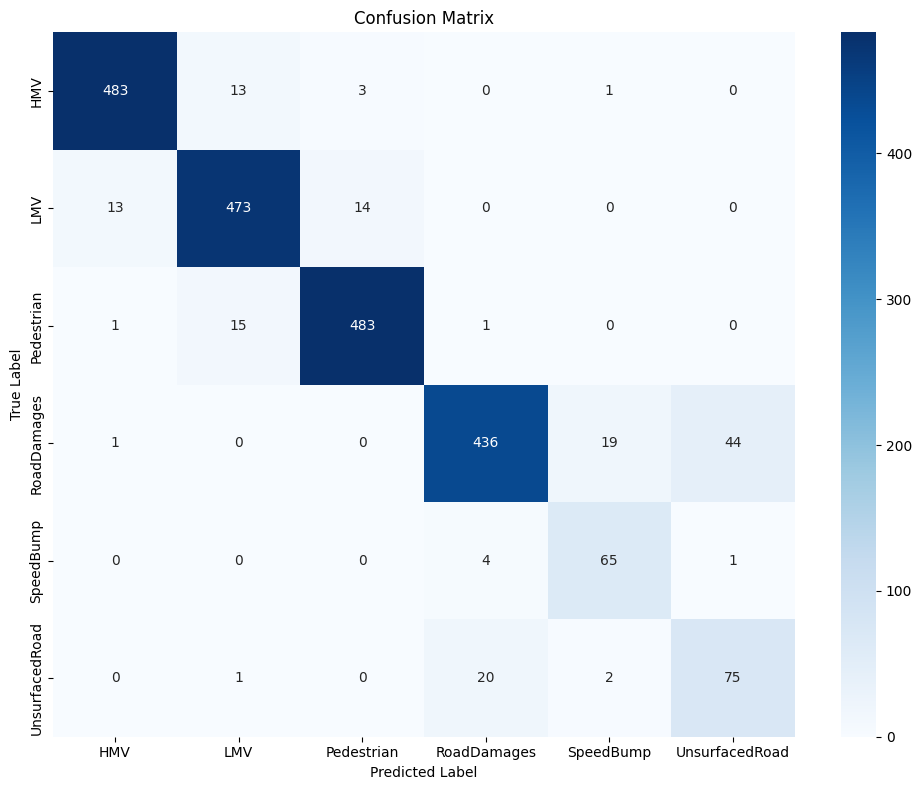

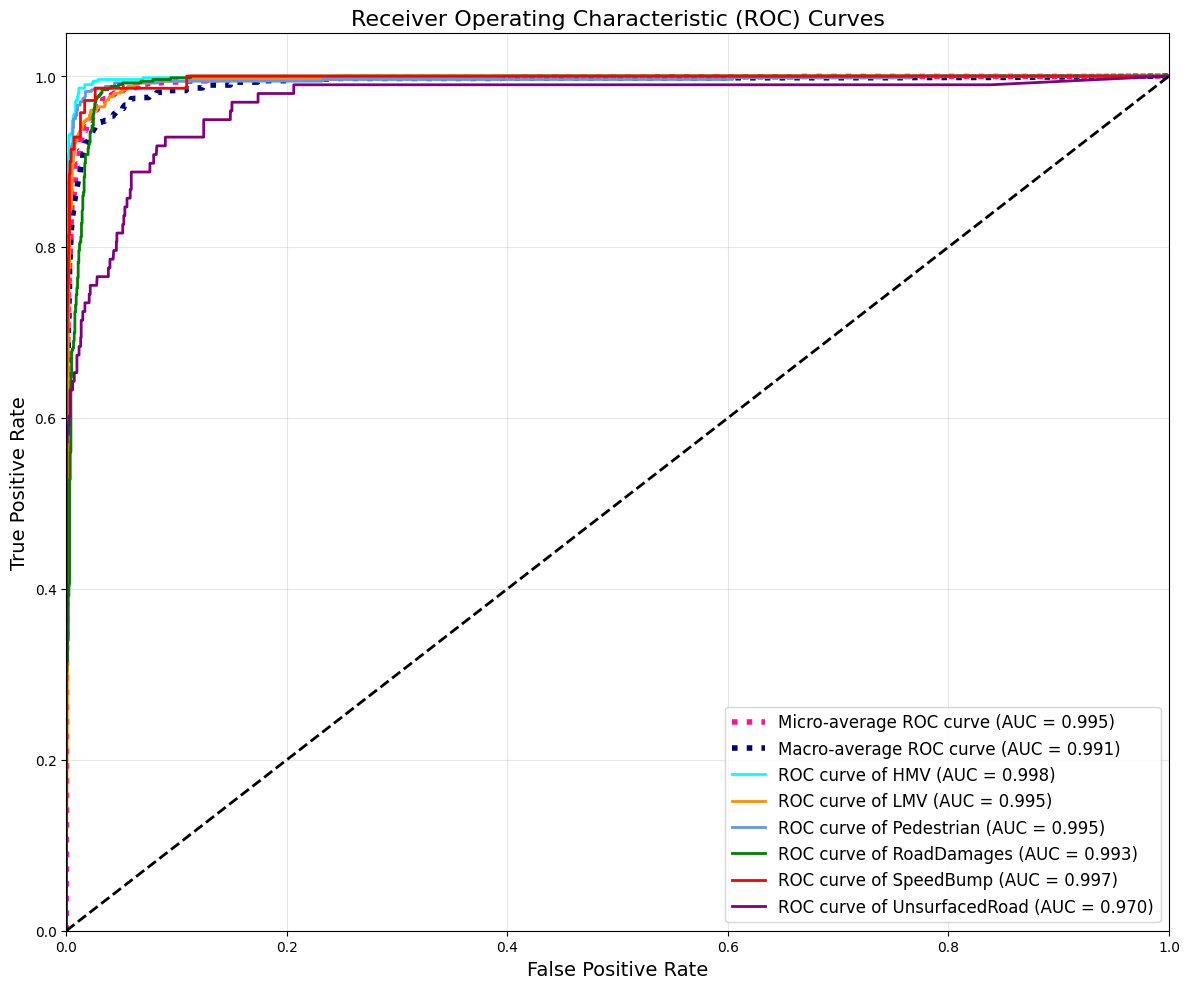


AUC scores for each class:
HMV: 0.9981
LMV: 0.9950
Pedestrian: 0.9954
RoadDamages: 0.9932
SpeedBump: 0.9968
UnsurfacedRoad: 0.9695
Micro-average AUC: 0.9945
Macro-average AUC: 0.9914


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# Clear TensorFlow session at the beginning
tf.keras.backend.clear_session()

# Set path to organized dataset
DATASET_PATH = '/content/dataset/kaggle/working/organized_dataset'

# Set constants - optimized for memory efficiency
IMG_HEIGHT = 160  # Reduced from 224
IMG_WIDTH = 160   # Reduced from 224
BATCH_SIZE = 8    # Small batch size to save memory
EPOCHS = 30       # Increased as requested
CLASS_NAMES = ['HMV', 'LMV', 'Pedestrian', 'RoadDamages', 'SpeedBump', 'UnsurfacedRoad']
NUM_CLASSES = len(CLASS_NAMES)

# Configure TensorFlow to be memory efficient
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Found {len(gpus)} GPU(s)")
    try:
        # Limit GPU memory usage
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # 4GB limit
            )
        print("GPU memory limit set to 4GB")
    except RuntimeError as e:
        # Configuration must be set before GPUs have been initialized
        print(f"GPU configuration error: {e}")

# Enable mixed precision training to save memory
try:
    from tensorflow.keras.mixed_precision import set_global_policy
    set_global_policy('mixed_float16')
    print("Mixed precision training enabled (float16)")
except:
    print("Could not enable mixed precision training")

# Create data generators with augmentation for training
def create_data_generators():
    # Training data with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Validation and test data only get rescaled
    val_test_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Create generators
    train_dir = os.path.join(DATASET_PATH, 'train')
    val_dir = os.path.join(DATASET_PATH, 'valid')
    test_dir = os.path.join(DATASET_PATH, 'test')

    # Check if directories exist
    train_exists = os.path.exists(train_dir)
    val_exists = os.path.exists(val_dir)
    test_exists = os.path.exists(test_dir)

    if not train_exists:
        print(f"Warning: Training directory not found at {train_dir}")

    # Training generator
    train_generator = None
    train_samples = 0
    if train_exists:
        print(f"Creating training generator from {train_dir}")
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            classes=CLASS_NAMES,
            shuffle=True
        )
        train_samples = train_generator.samples
        print(f"Found {train_samples} training images in {len(train_generator.class_indices)} classes")

    # Validation generator
    val_generator = None
    val_samples = 0
    if val_exists:
        print(f"Creating validation generator from {val_dir}")
        val_generator = val_test_datagen.flow_from_directory(
            val_dir,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            classes=CLASS_NAMES,
            shuffle=False
        )
        val_samples = val_generator.samples
        print(f"Found {val_samples} validation images")

    # Test generator
    test_generator = None
    test_samples = 0
    if test_exists:
        print(f"Creating test generator from {test_dir}")
        test_generator = val_test_datagen.flow_from_directory(
            test_dir,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            classes=CLASS_NAMES,
            shuffle=False
        )
        test_samples = test_generator.samples
        print(f"Found {test_samples} test images")

    return train_generator, val_generator, test_generator, train_samples, val_samples, test_samples

# Create DenseNet121 model with properly initialized weights
def build_densenet_model():
    # Create base model with pre-trained weights and without the classification layers
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Create the complete model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

# Function to train model in two phases (transfer learning)
def train_densenet_model():
    # Create data generators
    train_generator, val_generator, test_generator, train_samples, val_samples, test_samples = create_data_generators()

    if train_generator is None or train_samples == 0:
        print("No training data found. Exiting.")
        return

    # Calculate steps
    steps_per_epoch = train_samples // BATCH_SIZE
    validation_steps = val_samples // BATCH_SIZE if val_samples > 0 else None

    # Build model
    print("\nBuilding DenseNet121 model...")
    model, base_model = build_densenet_model()
    model.summary()

    # Callbacks
    checkpoint = ModelCheckpoint(
        'best_densenet_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )

    callbacks = [checkpoint, early_stopping, reduce_lr]

    # Phase 1: Train only the classification head
    print("\nPhase 1: Training only the classification head...")
    history1 = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS // 2,  # First half of epochs for phase 1
        validation_data=val_generator if val_samples > 0 else None,
        validation_steps=validation_steps,
        callbacks=callbacks
    )

    # Phase 2: Fine-tune the model by unfreezing some layers
    print("\nPhase 2: Fine-tuning the model...")

    # Unfreeze the last few Dense blocks of DenseNet
    for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
        layer.trainable = True

    # Recompile with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Continue training
    history2 = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS // 2,  # Second half of epochs for phase 2
        validation_data=val_generator if val_samples > 0 else None,
        validation_steps=validation_steps,
        callbacks=callbacks
    )

    # Save final model
    model.save('final_densenet_model.keras')
    print("Model saved to final_densenet_model.keras")

    # Combine histories
    combined_history = {}
    for k in history1.history.keys():
        combined_history[k] = history1.history[k] + history2.history[k]

    # Plot training history
    plot_training_history(combined_history, val_samples > 0)

    # Evaluate on test set
    if test_generator is not None and test_samples > 0:
        evaluate_model(model, test_generator, test_samples)
    else:
        print("No test data available for evaluation")

# Plot training history
def plot_training_history(history, has_validation):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    if has_validation:
        plt.plot(history['val_accuracy'])
        plt.legend(['Train', 'Validation'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    if has_validation:
        plt.plot(history['val_loss'])
        plt.legend(['Train', 'Validation'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.tight_layout()
    plt.savefig('densenet_training_history.png')
    plt.close()  # Close figure to free memory
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

def plot_roc_curves(y_true, y_pred_proba, class_names):
    """
    Plot ROC curves and calculate AUC for multi-class classification.
    """
    n_classes = len(class_names)

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Calculate ROC curve and AUC for each class
    for i in range(n_classes):
        # For each class, calculate the ROC curve using one-vs-rest approach
        class_true = (y_true == i).astype(int)
        class_score = y_pred_proba[:, i]

        fpr[i], tpr[i], _ = roc_curve(class_true, class_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calculate macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    macro_roc_auc = auc(all_fpr, mean_tpr)

    # Calculate micro-average ROC curve and AUC
    # Flatten predictions and true values
    y_true_flatten = np.zeros((y_true.size, n_classes))
    for i in range(n_classes):
        y_true_flatten[:, i] = (y_true == i)

    y_pred_flatten = y_pred_proba.ravel()
    y_true_flatten = y_true_flatten.ravel()

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_flatten, y_pred_flatten)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(12, 10))

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.3f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Plot macro-average ROC curve
    plt.plot(all_fpr, mean_tpr,
             label=f'Macro-average ROC curve (AUC = {macro_roc_auc:.3f})',
             color='navy', linestyle=':', linewidth=4)

    # Plot ROC curves for all classes
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.3f})')

    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('densenet_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()  # Added plt.show() here
    plt.close()

    # Print AUC scores for each class
    print("\nAUC scores for each class:")
    for i in range(n_classes):
        print(f"{class_names[i]}: {roc_auc[i]:.4f}")

    print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average AUC: {macro_roc_auc:.4f}")

    return roc_auc
def evaluate_model(model, test_generator, test_samples):
    print("\nEvaluating on test set...")

    # Reset generator
    test_generator.reset()

    # Evaluate model
    test_loss, test_acc = model.evaluate(test_generator, steps=test_samples//BATCH_SIZE)
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Generate predictions
    test_generator.reset()
    steps = (test_samples // BATCH_SIZE) + (1 if test_samples % BATCH_SIZE > 0 else 0)

    # Collect true labels and predictions
    y_true = []
    y_pred = []
    y_pred_proba = []  # Added to store prediction probabilities for ROC

    for i in tqdm(range(steps), desc="Generating predictions"):
        x_batch, y_batch = next(test_generator)

        # If we're at the last batch and it's not a full batch
        if i == steps - 1 and test_samples % BATCH_SIZE > 0:
            # Only predict on the actual number of samples in this batch
            actual_batch_size = test_samples % BATCH_SIZE
            batch_preds = model.predict(x_batch[:actual_batch_size])
            batch_true = y_batch[:actual_batch_size]
        else:
            batch_preds = model.predict(x_batch)
            batch_true = y_batch

        # Convert one-hot encoded labels back to class indices
        batch_pred_classes = np.argmax(batch_preds, axis=1)
        batch_true_classes = np.argmax(batch_true, axis=1)

        y_true.extend(batch_true_classes)
        y_pred.extend(batch_pred_classes)
        y_pred_proba.append(batch_preds)  # Store probabilities for ROC curve

        # Free memory
        del x_batch, y_batch

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_proba = np.vstack(y_pred_proba)  # Stack all prediction probabilities

    # Classification report
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
    print(report)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('densenet_confusion_matrix.png')
    plt.show()  # Added plt.show() here
    plt.close()  # Close figure to free memory

    # Plot ROC curves
    plot_roc_curves(y_true, y_pred_proba, CLASS_NAMES)

if __name__ == "__main__":
    # Print TensorFlow version
    print(f"TensorFlow version: {tf.__version__}")

    # Check for GPU availability
    print("GPU Available: ", tf.config.list_physical_devices('GPU'))

    # Start training
    train_densenet_model()

Found 1 GPU(s)
GPU memory limit set to 4GB
Mixed precision training enabled (float16)
TensorFlow version: 2.18.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Creating training generator from /content/dataset/kaggle/working/organized_dataset/train
Found 2751 images belonging to 6 classes.
Found 2751 training images in 6 classes
Creating validation generator from /content/dataset/kaggle/working/organized_dataset/valid
Found 2173 images belonging to 6 classes.
Found 2173 validation images
Creating test generator from /content/dataset/kaggle/working/organized_dataset/test
Found 2168 images belonging to 6 classes.
Found 2168 test images

Building VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 160, 160, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 160, 160, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 40, 40, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 20, 20, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,110,214 (57.64 MB)

 Trainable params: 395,526 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


Phase 1: Training only the classification head...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


343/343 ━━━━━━━━━━━━━━━━━━━━ 37s 88ms/step - accuracy: 0.4329 - loss: 1.3215 - val_accuracy: 0.7403 - val_loss: 0.6242 - learning_rate: 0.0010
Epoch 2/15
  1/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5000 - loss: 0.7638

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


343/343 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5000 - loss: 0.7638 - val_accuracy: 0.7385 - val_loss: 0.6296 - learning_rate: 0.0010
Epoch 3/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.6313 - loss: 0.8280 - val_accuracy: 0.8113 - val_loss: 0.5141 - learning_rate: 0.0010
Epoch 4/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3750 - loss: 1.1865 - val_accuracy: 0.8095 - val_loss: 0.5168 - learning_rate: 0.0010
Epoch 5/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 82s 127ms/step - accuracy: 0.7160 - loss: 0.6996 - val_accuracy: 0.8256 - val_loss: 0.4772 - learning_rate: 0.0010
Epoch 6/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6250 - loss: 0.6109 - val_accuracy: 0.8155 - val_loss: 0.4849 - learning_rate: 0.0010
Epoch 7/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 60s 71ms/step - accuracy: 0.7002 - loss: 0.7346 - val_accuracy: 0.7980 - val_loss: 0.4987 - learning_rate: 0.0010
Epoch 8/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3750 - loss: 1.1667 - va

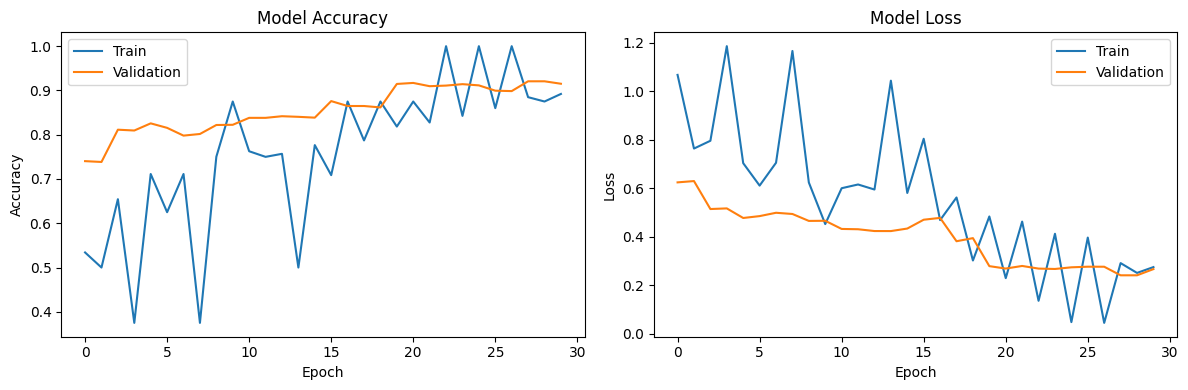


Evaluating on test set...
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9702 - loss: 0.1034
Test accuracy: 0.9373
Test loss: 0.2066


Generating predictions:   0%|          | 0/271 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


Generating predictions:   0%|          | 1/271 [00:00<03:54,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Generating predictions:   1%|          | 2/271 [00:00<01:54,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Generating predictions:   1%|▏         | 4/271 [00:01<00:56,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Generating predictions:   2%|▏         | 5/271 [00:01<00:48,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Generating predictions:   2%|▏         | 6/271 [00:01<00:43,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Generating predictions:   3%|▎         | 8/271 [00:01<00:35,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Generating predictions:   3%|▎         | 9/271 [00:01<00:33,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:   4%|▎         | 10/271 [00:01<00:33,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:   4%|▍         | 12/271 [00:01<00:28,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:   5%|▌         | 14/271 [00:02<00:27,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:   6%|▌         | 15/271 [00:02<00:28,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:   6%|▋         | 17/271 [00:02<00:27,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:   7%|▋         | 18/271 [00:02<00:27,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:   7%|▋         | 20/271 [00:02<00:25,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:   8%|▊         | 21/271 [00:02<00:26,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:   8%|▊         | 22/271 [00:03<00:26,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:   8%|▊         | 23/271 [00:03<00:27,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:   9%|▉         | 25/271 [00:03<00:26,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  10%|▉         | 26/271 [00:03<00:26,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  10%|▉         | 27/271 [00:03<00:26,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  10%|█         | 28/271 [00:03<00:26,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  11%|█         | 29/271 [00:03<00:27,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  11%|█▏        | 31/271 [00:04<00:24,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  12%|█▏        | 33/271 [00:04<00:24,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  13%|█▎        | 34/271 [00:04<00:25,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  13%|█▎        | 35/271 [00:04<00:25,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions:  13%|█▎        | 36/271 [00:04<00:27,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  14%|█▎        | 37/271 [00:04<00:28,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  14%|█▍        | 38/271 [00:04<00:29,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  14%|█▍        | 39/271 [00:05<00:30,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Generating predictions:  15%|█▍        | 40/271 [00:05<00:30,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  15%|█▌        | 41/271 [00:05<00:31,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  15%|█▌        | 42/271 [00:05<00:30,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Generating predictions:  16%|█▌        | 43/271 [00:05<00:31,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions:  16%|█▌        | 44/271 [00:05<00:33,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Generating predictions:  17%|█▋        | 45/271 [00:05<00:33,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  17%|█▋        | 46/271 [00:06<00:32,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  17%|█▋        | 47/271 [00:06<00:31,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Generating predictions:  18%|█▊        | 48/271 [00:06<00:29,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Generating predictions:  18%|█▊        | 49/271 [00:06<00:29,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Generating predictions:  18%|█▊        | 50/271 [00:06<00:29,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Generating predictions:  19%|█▉        | 51/271 [00:06<00:29,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  19%|█▉        | 52/271 [00:06<00:30,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Generating predictions:  20%|█▉        | 53/271 [00:06<00:30,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  20%|█▉        | 54/271 [00:07<00:31,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  20%|██        | 55/271 [00:07<00:31,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  21%|██        | 56/271 [00:07<00:31,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Generating predictions:  21%|██        | 57/271 [00:07<00:30,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  21%|██▏       | 58/271 [00:07<00:28,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  22%|██▏       | 60/271 [00:07<00:25,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  23%|██▎       | 61/271 [00:08<00:25,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  23%|██▎       | 62/271 [00:08<00:25,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  24%|██▎       | 64/271 [00:08<00:22,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  24%|██▍       | 66/271 [00:08<00:20, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  25%|██▌       | 68/271 [00:08<00:20,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  26%|██▌       | 70/271 [00:08<00:19, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  27%|██▋       | 72/271 [00:09<00:19, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  27%|██▋       | 73/271 [00:09<00:20,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:  27%|██▋       | 74/271 [00:09<00:21,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  28%|██▊       | 75/271 [00:09<00:21,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  28%|██▊       | 77/271 [00:09<00:21,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  29%|██▉       | 78/271 [00:09<00:21,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  29%|██▉       | 79/271 [00:09<00:22,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  30%|██▉       | 80/271 [00:10<00:22,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  30%|██▉       | 81/271 [00:10<00:22,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  31%|███       | 83/271 [00:10<00:19,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  31%|███▏      | 85/271 [00:10<00:19,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  32%|███▏      | 86/271 [00:10<00:19,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  32%|███▏      | 88/271 [00:10<00:18,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  33%|███▎      | 89/271 [00:10<00:19,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  34%|███▎      | 91/271 [00:11<00:18,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  34%|███▍      | 93/271 [00:11<00:17, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  35%|███▍      | 94/271 [00:11<00:18,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  35%|███▌      | 95/271 [00:11<00:18,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  35%|███▌      | 96/271 [00:11<00:19,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  36%|███▌      | 97/271 [00:11<00:19,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  36%|███▌      | 98/271 [00:11<00:19,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  37%|███▋      | 100/271 [00:12<00:19,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  38%|███▊      | 102/271 [00:12<00:18,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  38%|███▊      | 104/271 [00:12<00:18,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  39%|███▊      | 105/271 [00:12<00:18,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  39%|███▉      | 106/271 [00:12<00:18,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  39%|███▉      | 107/271 [00:12<00:18,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  40%|████      | 109/271 [00:13<00:16,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  41%|████      | 110/271 [00:13<00:17,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  41%|████▏     | 112/271 [00:13<00:16,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  42%|████▏     | 113/271 [00:13<00:16,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  42%|████▏     | 114/271 [00:13<00:17,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  43%|████▎     | 116/271 [00:13<00:15, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  44%|████▎     | 118/271 [00:14<00:15,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:  44%|████▍     | 120/271 [00:14<00:14, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  45%|████▌     | 122/271 [00:14<00:14, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  46%|████▌     | 124/271 [00:14<00:14, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  46%|████▋     | 126/271 [00:14<00:13, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  47%|████▋     | 128/271 [00:14<00:13, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  48%|████▊     | 130/271 [00:15<00:14,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  49%|████▊     | 132/271 [00:15<00:14,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  49%|████▉     | 133/271 [00:15<00:14,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  49%|████▉     | 134/271 [00:15<00:14,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  50%|████▉     | 135/271 [00:15<00:14,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  50%|█████     | 136/271 [00:15<00:14,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  51%|█████     | 138/271 [00:16<00:14,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  51%|█████▏    | 139/271 [00:16<00:14,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  52%|█████▏    | 140/271 [00:16<00:14,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  52%|█████▏    | 141/271 [00:16<00:14,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  52%|█████▏    | 142/271 [00:16<00:14,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  53%|█████▎    | 143/271 [00:16<00:14,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  54%|█████▎    | 145/271 [00:16<00:13,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  54%|█████▍    | 147/271 [00:17<00:12,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  55%|█████▍    | 148/271 [00:17<00:13,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  55%|█████▍    | 149/271 [00:17<00:13,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  55%|█████▌    | 150/271 [00:17<00:13,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  56%|█████▌    | 152/271 [00:17<00:12,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Generating predictions:  56%|█████▋    | 153/271 [00:17<00:13,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Generating predictions:  57%|█████▋    | 154/271 [00:17<00:14,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions:  57%|█████▋    | 155/271 [00:18<00:14,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Generating predictions:  58%|█████▊    | 156/271 [00:18<00:15,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Generating predictions:  58%|█████▊    | 157/271 [00:18<00:15,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  58%|█████▊    | 158/271 [00:18<00:14,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  59%|█████▊    | 159/271 [00:18<00:14,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Generating predictions:  59%|█████▉    | 160/271 [00:18<00:15,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Generating predictions:  59%|█████▉    | 161/271 [00:18<00:15,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Generating predictions:  60%|█████▉    | 162/271 [00:19<00:15,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Generating predictions:  60%|██████    | 163/271 [00:19<00:15,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  61%|██████    | 164/271 [00:19<00:14,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Generating predictions:  61%|██████    | 165/271 [00:19<00:14,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  61%|██████▏   | 166/271 [00:19<00:14,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Generating predictions:  62%|██████▏   | 167/271 [00:19<00:14,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Generating predictions:  62%|██████▏   | 168/271 [00:19<00:13,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Generating predictions:  62%|██████▏   | 169/271 [00:19<00:13,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Generating predictions:  63%|██████▎   | 170/271 [00:20<00:13,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Generating predictions:  63%|██████▎   | 171/271 [00:20<00:13,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Generating predictions:  63%|██████▎   | 172/271 [00:20<00:13,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  64%|██████▍   | 173/271 [00:20<00:14,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions:  64%|██████▍   | 174/271 [00:20<00:14,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  65%|██████▍   | 175/271 [00:20<00:13,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  65%|██████▍   | 176/271 [00:20<00:13,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  66%|██████▌   | 178/271 [00:21<00:11,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  66%|██████▋   | 180/271 [00:21<00:10,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:  67%|██████▋   | 182/271 [00:21<00:09,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  68%|██████▊   | 184/271 [00:21<00:08,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  69%|██████▊   | 186/271 [00:21<00:08,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  69%|██████▉   | 187/271 [00:22<00:08,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  69%|██████▉   | 188/271 [00:22<00:08,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  70%|██████▉   | 189/271 [00:22<00:08,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  70%|███████   | 190/271 [00:22<00:08,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  71%|███████   | 192/271 [00:22<00:08,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  71%|███████   | 193/271 [00:22<00:08,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  72%|███████▏  | 195/271 [00:22<00:07, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  72%|███████▏  | 196/271 [00:23<00:07,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  73%|███████▎  | 198/271 [00:23<00:07,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  74%|███████▍  | 200/271 [00:23<00:07,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  74%|███████▍  | 201/271 [00:23<00:07,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  75%|███████▍  | 202/271 [00:23<00:07,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  75%|███████▌  | 204/271 [00:23<00:06,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  76%|███████▌  | 206/271 [00:24<00:06,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  77%|███████▋  | 208/271 [00:24<00:06,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  77%|███████▋  | 209/271 [00:24<00:06,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  77%|███████▋  | 210/271 [00:24<00:06,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  78%|███████▊  | 212/271 [00:24<00:06,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  79%|███████▊  | 213/271 [00:24<00:06,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  79%|███████▉  | 214/271 [00:24<00:06,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  79%|███████▉  | 215/271 [00:25<00:06,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  80%|███████▉  | 216/271 [00:25<00:06,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  80%|████████  | 217/271 [00:25<00:06,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  80%|████████  | 218/271 [00:25<00:06,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  81%|████████  | 219/271 [00:25<00:06,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  81%|████████  | 220/271 [00:25<00:06,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  82%|████████▏ | 221/271 [00:25<00:06,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  82%|████████▏ | 222/271 [00:25<00:06,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  82%|████████▏ | 223/271 [00:26<00:05,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  83%|████████▎ | 225/271 [00:26<00:05,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  83%|████████▎ | 226/271 [00:26<00:05,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  84%|████████▍ | 227/271 [00:26<00:05,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  84%|████████▍ | 228/271 [00:26<00:04,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  85%|████████▍ | 229/271 [00:26<00:04,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  85%|████████▍ | 230/271 [00:26<00:04,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  85%|████████▌ | 231/271 [00:26<00:04,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  86%|████████▌ | 233/271 [00:27<00:04,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  87%|████████▋ | 235/271 [00:27<00:03,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  87%|████████▋ | 236/271 [00:27<00:03,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  87%|████████▋ | 237/271 [00:27<00:03,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  88%|████████▊ | 239/271 [00:27<00:03,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  89%|████████▊ | 240/271 [00:27<00:03,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  89%|████████▉ | 241/271 [00:28<00:03,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  90%|████████▉ | 243/271 [00:28<00:03,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  90%|█████████ | 244/271 [00:28<00:03,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  91%|█████████ | 246/271 [00:28<00:02,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  91%|█████████ | 247/271 [00:28<00:02,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  92%|█████████▏| 248/271 [00:28<00:02,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  92%|█████████▏| 250/271 [00:29<00:02,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  93%|█████████▎| 251/271 [00:29<00:02,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  93%|█████████▎| 252/271 [00:29<00:02,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  93%|█████████▎| 253/271 [00:29<00:02,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  94%|█████████▎| 254/271 [00:29<00:01,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  94%|█████████▍| 255/271 [00:29<00:01,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  95%|█████████▍| 257/271 [00:29<00:01,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  95%|█████████▌| 258/271 [00:29<00:01,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  96%|█████████▌| 260/271 [00:30<00:01,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  97%|█████████▋| 262/271 [00:30<00:00, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  97%|█████████▋| 264/271 [00:30<00:00,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  98%|█████████▊| 265/271 [00:30<00:00,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  99%|█████████▊| 267/271 [00:30<00:00, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  99%|█████████▉| 269/271 [00:31<00:00,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Generating predictions: 100%|█████████▉| 270/271 [00:31<00:00,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Generating predictions: 100%|██████████| 271/271 [00:31<00:00,  8.59it/s]


===== COMPREHENSIVE EVALUATION METRICS =====
Overall Accuracy: 0.9373

Weighted Metrics (accounts for class imbalance):
Weighted Precision: 0.9383
Weighted Recall: 0.9373
Weighted F1-score: 0.9377

Per-class Metrics:
Class               Precision    Recall       F1-Score
------------------------------------------------------------
HMV                0.9704       0.9840       0.9772
LMV                0.9540       0.9540       0.9540
Pedestrian         0.9778       0.9680       0.9729
RoadDamages        0.9303       0.9080       0.9190
SpeedBump          0.8378       0.8857       0.8611
UnsurfacedRoad     0.6058       0.6429       0.6238

Detailed Classification Report:
                precision    recall  f1-score   support

           HMV       0.97      0.98      0.98       500
           LMV       0.95      0.95      0.95       500
    Pedestrian       0.98      0.97      0.97       500
   RoadDamages       0.93      0.91      0.92       500
     SpeedBump       0.84      0.89     

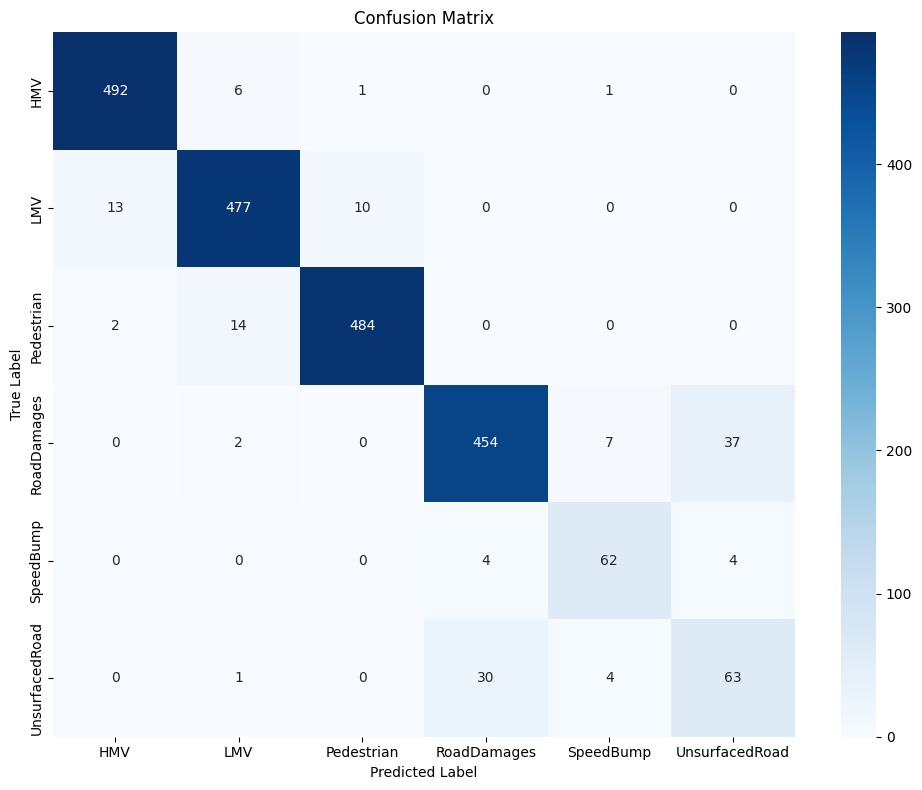

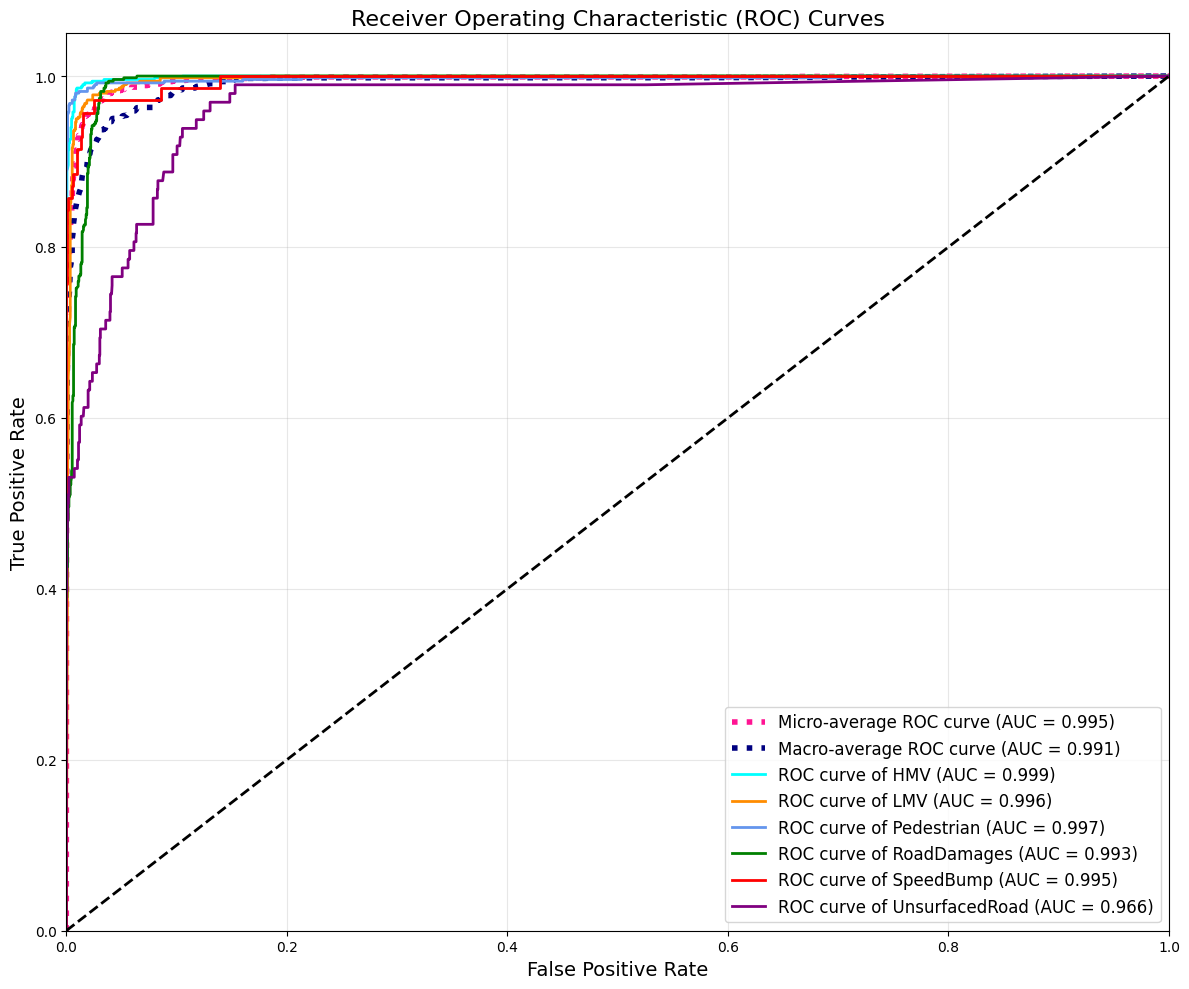


AUC scores for each class:
HMV: 0.9989
LMV: 0.9962
Pedestrian: 0.9972
RoadDamages: 0.9931
SpeedBump: 0.9953
UnsurfacedRoad: 0.9657
Micro-average AUC: 0.9954
Macro-average AUC: 0.9912


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
from tqdm import tqdm
from itertools import cycle

# Clear TensorFlow session at the beginning
tf.keras.backend.clear_session()

# Set path to organized dataset
DATASET_PATH = '/content/dataset/kaggle/working/organized_dataset'

# Set constants - optimized for memory efficiency
IMG_HEIGHT = 160  # Reduced from 224
IMG_WIDTH = 160   # Reduced from 224
BATCH_SIZE = 8    # Small batch size to save memory
EPOCHS = 30       # Increased as requested
CLASS_NAMES = ['HMV', 'LMV', 'Pedestrian', 'RoadDamages', 'SpeedBump', 'UnsurfacedRoad']
NUM_CLASSES = len(CLASS_NAMES)

# Configure TensorFlow to be memory efficient
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Found {len(gpus)} GPU(s)")
    try:
        # Limit GPU memory usage
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # 4GB limit
            )
        print("GPU memory limit set to 4GB")
    except RuntimeError as e:
        # Configuration must be set before GPUs have been initialized
        print(f"GPU configuration error: {e}")

# Enable mixed precision training to save memory
try:
    from tensorflow.keras.mixed_precision import set_global_policy
    set_global_policy('mixed_float16')
    print("Mixed precision training enabled (float16)")
except:
    print("Could not enable mixed precision training")

# Create data generators with augmentation for training
def create_data_generators():
    # Training data with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Validation and test data only get rescaled
    val_test_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Create generators
    train_dir = os.path.join(DATASET_PATH, 'train')
    val_dir = os.path.join(DATASET_PATH, 'valid')
    test_dir = os.path.join(DATASET_PATH, 'test')

    # Check if directories exist
    train_exists = os.path.exists(train_dir)
    val_exists = os.path.exists(val_dir)
    test_exists = os.path.exists(test_dir)

    if not train_exists:
        print(f"Warning: Training directory not found at {train_dir}")

    # Training generator
    train_generator = None
    train_samples = 0
    if train_exists:
        print(f"Creating training generator from {train_dir}")
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            classes=CLASS_NAMES,
            shuffle=True
        )
        train_samples = train_generator.samples
        print(f"Found {train_samples} training images in {len(train_generator.class_indices)} classes")

    # Validation generator
    val_generator = None
    val_samples = 0
    if val_exists:
        print(f"Creating validation generator from {val_dir}")
        val_generator = val_test_datagen.flow_from_directory(
            val_dir,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            classes=CLASS_NAMES,
            shuffle=False
        )
        val_samples = val_generator.samples
        print(f"Found {val_samples} validation images")

    # Test generator
    test_generator = None
    test_samples = 0
    if test_exists:
        print(f"Creating test generator from {test_dir}")
        test_generator = val_test_datagen.flow_from_directory(
            test_dir,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            classes=CLASS_NAMES,
            shuffle=False
        )
        test_samples = test_generator.samples
        print(f"Found {test_samples} test images")

    return train_generator, val_generator, test_generator, train_samples, val_samples, test_samples

# Create VGG16 model with properly initialized weights
def build_vgg16_model():
    # Create base model with pre-trained weights and without the classification layers
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Create the complete model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

# Function to train model in two phases (transfer learning)
def train_vgg16_model():
    # Create data generators
    train_generator, val_generator, test_generator, train_samples, val_samples, test_samples = create_data_generators()

    if train_generator is None or train_samples == 0:
        print("No training data found. Exiting.")
        return

    # Calculate steps
    steps_per_epoch = train_samples // BATCH_SIZE
    validation_steps = val_samples // BATCH_SIZE if val_samples > 0 else None

    # Build model
    print("\nBuilding VGG16 model...")
    model, base_model = build_vgg16_model()
    model.summary()

    # Callbacks
    checkpoint = ModelCheckpoint(
        'best_vgg16_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )

    callbacks = [checkpoint, early_stopping, reduce_lr]

    # Phase 1: Train only the classification head
    print("\nPhase 1: Training only the classification head...")
    history1 = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS // 2,  # First half of epochs for phase 1
        validation_data=val_generator if val_samples > 0 else None,
        validation_steps=validation_steps,
        callbacks=callbacks
    )

    # Phase 2: Fine-tune the model by unfreezing some layers
    print("\nPhase 2: Fine-tuning the model...")

    # Unfreeze the last few blocks of VGG16
    # VGG16 has 5 blocks, so we'll unfreeze the last block (block5)
    for layer in base_model.layers[-4:]:  # Last 4 layers of the last block
        layer.trainable = True

    # Recompile with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Continue training
    history2 = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS // 2,  # Second half of epochs for phase 2
        validation_data=val_generator if val_samples > 0 else None,
        validation_steps=validation_steps,
        callbacks=callbacks
    )

    # Save final model
    model.save('final_vgg16_model.keras')
    print("Model saved to final_vgg16_model.keras")

    # Combine histories
    combined_history = {}
    for k in history1.history.keys():
        combined_history[k] = history1.history[k] + history2.history[k]

    # Plot training history
    plot_training_history(combined_history, val_samples > 0)

    # Evaluate on test set
    if test_generator is not None and test_samples > 0:
        evaluate_model(model, test_generator, test_samples)
    else:
        print("No test data available for evaluation")

# Plot training history
def plot_training_history(history, has_validation):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    if has_validation:
        plt.plot(history['val_accuracy'])
        plt.legend(['Train', 'Validation'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    if has_validation:
        plt.plot(history['val_loss'])
        plt.legend(['Train', 'Validation'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.tight_layout()
    plt.savefig('vgg16_training_history.png')
    plt.show()
    plt.close()  # Close figure to free memory

# Plot ROC curves
def plot_roc_curves(y_true, y_pred_proba, class_names):
    """
    Plot ROC curves and calculate AUC for multi-class classification.
    """
    n_classes = len(class_names)

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Calculate ROC curve and AUC for each class
    for i in range(n_classes):
        # For each class, calculate the ROC curve using one-vs-rest approach
        class_true = (y_true == i).astype(int)
        class_score = y_pred_proba[:, i]

        fpr[i], tpr[i], _ = roc_curve(class_true, class_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calculate macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    macro_roc_auc = auc(all_fpr, mean_tpr)

    # Calculate micro-average ROC curve and AUC
    # Flatten predictions and true values
    y_true_flatten = np.zeros((y_true.size, n_classes))
    for i in range(n_classes):
        y_true_flatten[:, i] = (y_true == i)

    y_pred_flatten = y_pred_proba.ravel()
    y_true_flatten = y_true_flatten.ravel()

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_flatten, y_pred_flatten)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(12, 10))

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.3f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Plot macro-average ROC curve
    plt.plot(all_fpr, mean_tpr,
             label=f'Macro-average ROC curve (AUC = {macro_roc_auc:.3f})',
             color='navy', linestyle=':', linewidth=4)

    # Plot ROC curves for all classes
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.3f})')

    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('vgg16_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Print AUC scores for each class
    print("\nAUC scores for each class:")
    for i in range(n_classes):
        print(f"{class_names[i]}: {roc_auc[i]:.4f}")

    print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average AUC: {macro_roc_auc:.4f}")

    return roc_auc

# Evaluate model on test set
def evaluate_model(model, test_generator, test_samples):
    print("\nEvaluating on test set...")

    # Reset generator
    test_generator.reset()

    # Evaluate model
    test_loss, test_acc = model.evaluate(test_generator, steps=test_samples//BATCH_SIZE)
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Generate predictions
    test_generator.reset()
    steps = (test_samples // BATCH_SIZE) + (1 if test_samples % BATCH_SIZE > 0 else 0)

    # Collect true labels and predictions
    y_true = []
    y_pred = []
    y_pred_proba = []  # Store probabilities for ROC curve

    for i in tqdm(range(steps), desc="Generating predictions"):
        x_batch, y_batch = next(test_generator)

        # If we're at the last batch and it's not a full batch
        if i == steps - 1 and test_samples % BATCH_SIZE > 0:
            # Only predict on the actual number of samples in this batch
            actual_batch_size = test_samples % BATCH_SIZE
            batch_preds = model.predict(x_batch[:actual_batch_size])
            batch_true = y_batch[:actual_batch_size]
        else:
            batch_preds = model.predict(x_batch)
            batch_true = y_batch

        # Convert one-hot encoded labels back to class indices
        batch_pred_classes = np.argmax(batch_preds, axis=1)
        batch_true_classes = np.argmax(batch_true, axis=1)

        y_true.extend(batch_true_classes)
        y_pred.extend(batch_pred_classes)
        y_pred_proba.append(batch_preds)

        # Free memory
        del x_batch, y_batch

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_proba = np.vstack(y_pred_proba)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    precision_class = precision_score(y_true, y_pred, average=None)
    recall_class = recall_score(y_true, y_pred, average=None)
    f1_class = f1_score(y_true, y_pred, average=None)

    # Print comprehensive evaluation metrics
    print("\n===== COMPREHENSIVE EVALUATION METRICS =====")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nWeighted Metrics (accounts for class imbalance):")
    print(f"Weighted Precision: {precision_weighted:.4f}")
    print(f"Weighted Recall: {recall_weighted:.4f}")
    print(f"Weighted F1-score: {f1_weighted:.4f}")

    print("\nPer-class Metrics:")
    print("Class               Precision    Recall       F1-Score")
    print("-" * 60)
    for i, class_name in enumerate(CLASS_NAMES):
        print(f"{class_name:<18} {precision_class[i]:.4f}       {recall_class[i]:.4f}       {f1_class[i]:.4f}")

    # Classification report (includes precision, recall, f1-score, support)
    print("\nDetailed Classification Report:")
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
    print(report)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('vgg16_confusion_matrix.png')
    plt.show()
    plt.close()  # Close figure to free memory

    # Plot ROC curves
    plot_roc_curves(y_true, y_pred_proba, CLASS_NAMES)

if __name__ == "__main__":
    # Print TensorFlow version
    print(f"TensorFlow version: {tf.__version__}")

    # Check for GPU availability
    print("GPU Available: ", tf.config.list_physical_devices('GPU'))

    # Start training
    train_vgg16_model()

Found 1 GPU(s)
GPU memory limit set to 4GB
Mixed precision training enabled (float16)
TensorFlow version: 2.18.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Creating training generator from /content/dataset/kaggle/working/organized_dataset/train
Found 2751 images belonging to 6 classes.
Found 2751 training images in 6 classes
Creating validation generator from /content/dataset/kaggle/working/organized_dataset/valid
Found 2173 images belonging to 6 classes.
Found 2173 validation images
Creating test generator from /content/dataset/kaggle/working/organized_dataset/test
Found 2168 images belonging to 6 classes.
Found 2168 test images

Building ResNet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 160, 160,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 166, 166,  │          0 │ cast[0][0]        │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 82, 82,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 40, 40,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 40, 40,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 40, 40,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 40, 40,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 40, 40,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 40, 40,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 40, 40,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 40, 40,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 40, 40,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_0_c

 Total params: 24,769,670 (94.49 MB)

 Trainable params: 1,181,958 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Phase 1: Training only the classification head...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


343/343 ━━━━━━━━━━━━━━━━━━━━ 56s 119ms/step - accuracy: 0.1924 - loss: 1.9030 - val_accuracy: 0.4566 - val_loss: 1.3917 - learning_rate: 0.0010
Epoch 2/15
  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1250 - loss: 1.4082

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


343/343 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1250 - loss: 1.4082 - val_accuracy: 0.4714 - val_loss: 1.3793 - learning_rate: 0.0010
Epoch 3/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 82s 150ms/step - accuracy: 0.3207 - loss: 1.4299 - val_accuracy: 0.4802 - val_loss: 1.1871 - learning_rate: 0.0010
Epoch 4/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2500 - loss: 1.3486 - val_accuracy: 0.4834 - val_loss: 1.1829 - learning_rate: 0.0010
Epoch 5/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.3988 - loss: 1.3194 - val_accuracy: 0.3413 - val_loss: 1.2118 - learning_rate: 0.0010
Epoch 6/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5000 - loss: 1.4065 - val_accuracy: 0.3298 - val_loss: 1.2152 - learning_rate: 0.0010
Epoch 7/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.3801 - loss: 1.2821 - val_accuracy: 0.5120 - val_loss: 1.2036 - learning_rate: 0.0010
Epoch 8/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.1250 - loss: 1.2010 - 

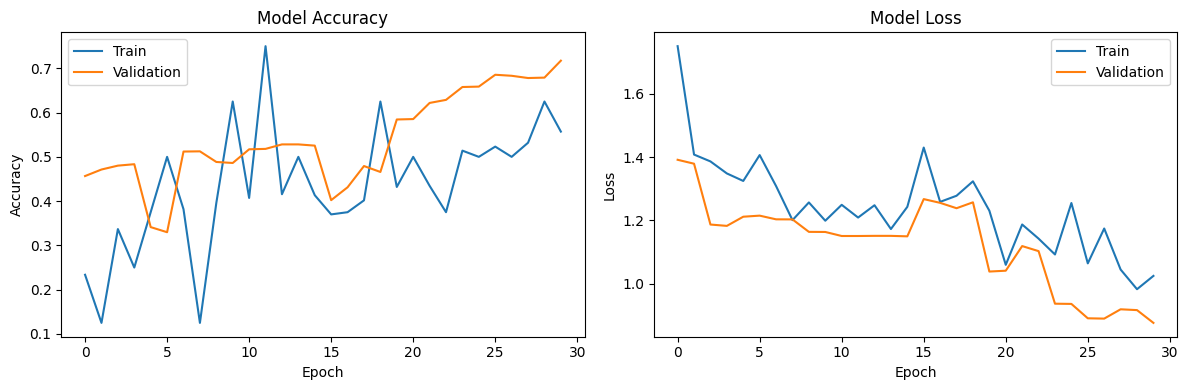


Evaluating on test set...
271/271 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8014 - loss: 0.5724
Test accuracy: 0.7514
Test loss: 0.7705


Generating predictions:   0%|          | 0/271 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Generating predictions:   0%|          | 1/271 [00:05<23:14,  5.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:   1%|          | 3/271 [00:05<06:17,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:   1%|▏         | 4/271 [00:05<04:17,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:   2%|▏         | 6/271 [00:05<02:22,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:   3%|▎         | 8/271 [00:05<01:34,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:   3%|▎         | 9/271 [00:06<01:20,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:   4%|▎         | 10/271 [00:06<01:08,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:   4%|▍         | 11/271 [00:06<00:58,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:   5%|▍         | 13/271 [00:06<00:44,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:   6%|▌         | 15/271 [00:06<00:36,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:   6%|▋         | 17/271 [00:06<00:31,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:   7%|▋         | 18/271 [00:06<00:30,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:   7%|▋         | 19/271 [00:07<00:30,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:   7%|▋         | 20/271 [00:07<00:30,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:   8%|▊         | 21/271 [00:07<00:30,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:   8%|▊         | 22/271 [00:07<00:29,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:   8%|▊         | 23/271 [00:07<00:29,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:   9%|▉         | 25/271 [00:07<00:26,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  10%|▉         | 27/271 [00:07<00:26,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  10%|█         | 28/271 [00:08<00:26,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  11%|█         | 29/271 [00:08<00:27,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  11%|█         | 30/271 [00:08<00:27,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  12%|█▏        | 32/271 [00:08<00:24,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  13%|█▎        | 34/271 [00:08<00:24,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  13%|█▎        | 35/271 [00:08<00:25,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:  13%|█▎        | 36/271 [00:08<00:25,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  14%|█▎        | 37/271 [00:09<00:27,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  14%|█▍        | 38/271 [00:09<00:26,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  14%|█▍        | 39/271 [00:09<00:26,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  15%|█▍        | 40/271 [00:09<00:26,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Generating predictions:  15%|█▌        | 41/271 [00:09<00:29,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions:  15%|█▌        | 42/271 [00:09<00:29,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Generating predictions:  16%|█▌        | 43/271 [00:09<00:30,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  16%|█▌        | 44/271 [00:10<00:31,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  17%|█▋        | 45/271 [00:10<00:31,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Generating predictions:  17%|█▋        | 46/271 [00:10<00:31,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  17%|█▋        | 47/271 [00:10<00:31,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  18%|█▊        | 48/271 [00:10<00:30,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  18%|█▊        | 49/271 [00:10<00:29,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Generating predictions:  18%|█▊        | 50/271 [00:10<00:30,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Generating predictions:  19%|█▉        | 51/271 [00:10<00:30,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Generating predictions:  19%|█▉        | 52/271 [00:11<00:31,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  20%|█▉        | 53/271 [00:11<00:30,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Generating predictions:  20%|█▉        | 54/271 [00:11<00:29,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Generating predictions:  20%|██        | 55/271 [00:11<00:28,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  21%|██        | 56/271 [00:11<00:28,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Generating predictions:  21%|██        | 57/271 [00:11<00:29,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Generating predictions:  21%|██▏       | 58/271 [00:11<00:30,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Generating predictions:  22%|██▏       | 59/271 [00:12<00:30,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Generating predictions:  22%|██▏       | 60/271 [00:12<00:31,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Generating predictions:  23%|██▎       | 61/271 [00:12<00:30,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Generating predictions:  23%|██▎       | 62/271 [00:12<00:30,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  23%|██▎       | 63/271 [00:12<00:30,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  24%|██▎       | 64/271 [00:12<00:29,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  24%|██▍       | 65/271 [00:12<00:28,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  24%|██▍       | 66/271 [00:13<00:26,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  25%|██▌       | 68/271 [00:13<00:23,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  25%|██▌       | 69/271 [00:13<00:24,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  26%|██▌       | 70/271 [00:13<00:23,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  26%|██▌       | 71/271 [00:13<00:23,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  27%|██▋       | 73/271 [00:13<00:21,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  27%|██▋       | 74/271 [00:13<00:21,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  28%|██▊       | 76/271 [00:14<00:19,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  28%|██▊       | 77/271 [00:14<00:20,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  29%|██▉       | 78/271 [00:14<00:21,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  29%|██▉       | 79/271 [00:14<00:21,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  30%|██▉       | 80/271 [00:14<00:22,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  30%|██▉       | 81/271 [00:14<00:22,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  30%|███       | 82/271 [00:14<00:22,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  31%|███       | 83/271 [00:14<00:22,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  31%|███       | 84/271 [00:15<00:22,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  32%|███▏      | 86/271 [00:15<00:19,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  32%|███▏      | 87/271 [00:15<00:20,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  32%|███▏      | 88/271 [00:15<00:20,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  33%|███▎      | 89/271 [00:15<00:21,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  33%|███▎      | 90/271 [00:15<00:20,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  34%|███▎      | 91/271 [00:15<00:21,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  34%|███▍      | 93/271 [00:16<00:20,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  35%|███▍      | 94/271 [00:16<00:20,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  35%|███▌      | 95/271 [00:16<00:21,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  35%|███▌      | 96/271 [00:16<00:20,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  36%|███▌      | 97/271 [00:16<00:20,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  36%|███▌      | 98/271 [00:16<00:20,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  37%|███▋      | 99/271 [00:16<00:20,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  37%|███▋      | 100/271 [00:16<00:20,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  37%|███▋      | 101/271 [00:17<00:20,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  38%|███▊      | 103/271 [00:17<00:19,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  38%|███▊      | 104/271 [00:17<00:19,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Generating predictions:  39%|███▊      | 105/271 [00:17<00:20,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  39%|███▉      | 107/271 [00:17<00:17,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  40%|███▉      | 108/271 [00:17<00:18,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  40%|████      | 109/271 [00:17<00:18,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  41%|████      | 110/271 [00:18<00:18,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  41%|████▏     | 112/271 [00:18<00:16,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  42%|████▏     | 113/271 [00:18<00:16,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  42%|████▏     | 114/271 [00:18<00:17,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  42%|████▏     | 115/271 [00:18<00:17,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  43%|████▎     | 116/271 [00:18<00:17,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  43%|████▎     | 117/271 [00:18<00:17,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  44%|████▎     | 118/271 [00:18<00:17,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  44%|████▍     | 119/271 [00:19<00:17,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  45%|████▍     | 121/271 [00:19<00:16,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  45%|████▌     | 122/271 [00:19<00:17,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  46%|████▌     | 124/271 [00:19<00:16,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:  46%|████▌     | 125/271 [00:19<00:16,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  46%|████▋     | 126/271 [00:19<00:16,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  47%|████▋     | 128/271 [00:20<00:16,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  48%|████▊     | 129/271 [00:20<00:16,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  48%|████▊     | 131/271 [00:20<00:15,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  49%|████▊     | 132/271 [00:20<00:15,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  49%|████▉     | 133/271 [00:20<00:16,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  49%|████▉     | 134/271 [00:20<00:16,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  50%|████▉     | 135/271 [00:20<00:16,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  50%|█████     | 136/271 [00:21<00:16,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  51%|█████     | 137/271 [00:21<00:16,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  51%|█████     | 138/271 [00:21<00:16,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  51%|█████▏    | 139/271 [00:21<00:16,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  52%|█████▏    | 140/271 [00:21<00:16,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  52%|█████▏    | 141/271 [00:21<00:16,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  52%|█████▏    | 142/271 [00:21<00:15,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  53%|█████▎    | 143/271 [00:21<00:15,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  54%|█████▎    | 145/271 [00:22<00:13,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  54%|█████▍    | 147/271 [00:22<00:13,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  55%|█████▍    | 149/271 [00:22<00:12,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  55%|█████▌    | 150/271 [00:22<00:13,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Generating predictions:  56%|█████▌    | 152/271 [00:22<00:13,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Generating predictions:  56%|█████▋    | 153/271 [00:23<00:14,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Generating predictions:  57%|█████▋    | 154/271 [00:23<00:14,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions:  57%|█████▋    | 155/271 [00:23<00:14,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Generating predictions:  58%|█████▊    | 156/271 [00:23<00:15,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Generating predictions:  58%|█████▊    | 157/271 [00:23<00:14,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Generating predictions:  58%|█████▊    | 158/271 [00:23<00:15,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Generating predictions:  59%|█████▊    | 159/271 [00:23<00:15,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  59%|█████▉    | 160/271 [00:23<00:15,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  59%|█████▉    | 161/271 [00:24<00:15,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Generating predictions:  60%|█████▉    | 162/271 [00:24<00:15,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Generating predictions:  60%|██████    | 163/271 [00:24<00:17,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Generating predictions:  61%|██████    | 164/271 [00:24<00:20,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Generating predictions:  61%|██████    | 165/271 [00:24<00:18,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Generating predictions:  61%|██████▏   | 166/271 [00:25<00:17,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  62%|██████▏   | 167/271 [00:25<00:15,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  62%|██████▏   | 168/271 [00:25<00:15,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Generating predictions:  62%|██████▏   | 169/271 [00:25<00:14,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  63%|██████▎   | 170/271 [00:25<00:14,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  63%|██████▎   | 171/271 [00:25<00:14,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Generating predictions:  63%|██████▎   | 172/271 [00:25<00:14,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Generating predictions:  64%|██████▍   | 173/271 [00:25<00:14,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Generating predictions:  64%|██████▍   | 174/271 [00:26<00:13,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Generating predictions:  65%|██████▍   | 175/271 [00:26<00:13,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  65%|██████▍   | 176/271 [00:26<00:12,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  65%|██████▌   | 177/271 [00:26<00:12,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  66%|██████▌   | 178/271 [00:26<00:12,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  66%|██████▋   | 180/271 [00:26<00:11,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  67%|██████▋   | 182/271 [00:27<00:09,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  68%|██████▊   | 184/271 [00:27<00:09,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  68%|██████▊   | 185/271 [00:27<00:09,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  69%|██████▉   | 187/271 [00:27<00:09,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  69%|██████▉   | 188/271 [00:27<00:09,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  70%|██████▉   | 189/271 [00:27<00:09,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  70%|███████   | 190/271 [00:27<00:09,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  71%|███████   | 192/271 [00:28<00:08,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  71%|███████   | 193/271 [00:28<00:09,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  72%|███████▏  | 195/271 [00:28<00:07,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  72%|███████▏  | 196/271 [00:28<00:08,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  73%|███████▎  | 197/271 [00:28<00:08,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Generating predictions:  73%|███████▎  | 198/271 [00:28<00:08,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  73%|███████▎  | 199/271 [00:28<00:08,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  74%|███████▍  | 200/271 [00:29<00:08,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  75%|███████▍  | 202/271 [00:29<00:07,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  75%|███████▌  | 204/271 [00:29<00:07,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  76%|███████▌  | 206/271 [00:29<00:06,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  77%|███████▋  | 208/271 [00:29<00:06,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  77%|███████▋  | 209/271 [00:30<00:06,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  78%|███████▊  | 211/271 [00:30<00:06,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  78%|███████▊  | 212/271 [00:30<00:06,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  79%|███████▊  | 213/271 [00:30<00:06,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  79%|███████▉  | 215/271 [00:30<00:06,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  80%|███████▉  | 216/271 [00:30<00:06,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  80%|████████  | 217/271 [00:30<00:06,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  81%|████████  | 219/271 [00:31<00:05,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  81%|████████  | 220/271 [00:31<00:05,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  82%|████████▏ | 222/271 [00:31<00:05,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  82%|████████▏ | 223/271 [00:31<00:05,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  83%|████████▎ | 225/271 [00:31<00:05,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  84%|████████▍ | 227/271 [00:32<00:04,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  85%|████████▍ | 229/271 [00:32<00:04,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  85%|████████▍ | 230/271 [00:32<00:04,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  86%|████████▌ | 232/271 [00:32<00:04,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  86%|████████▌ | 233/271 [00:32<00:03,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  87%|████████▋ | 235/271 [00:32<00:03, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  87%|████████▋ | 236/271 [00:32<00:03,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  87%|████████▋ | 237/271 [00:33<00:03,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  88%|████████▊ | 238/271 [00:33<00:03,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  89%|████████▊ | 240/271 [00:33<00:03,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  89%|████████▉ | 242/271 [00:33<00:02,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  90%|█████████ | 244/271 [00:33<00:02,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  90%|█████████ | 245/271 [00:33<00:02,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  91%|█████████ | 246/271 [00:34<00:02,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  92%|█████████▏| 248/271 [00:34<00:02,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  92%|█████████▏| 249/271 [00:34<00:02,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  93%|█████████▎| 251/271 [00:34<00:02,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  93%|█████████▎| 252/271 [00:34<00:02,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  93%|█████████▎| 253/271 [00:34<00:02,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  94%|█████████▎| 254/271 [00:34<00:01,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions:  94%|█████████▍| 255/271 [00:35<00:01,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  94%|█████████▍| 256/271 [00:35<00:01,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  95%|█████████▍| 257/271 [00:35<00:01,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  95%|█████████▌| 258/271 [00:35<00:01,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  96%|█████████▌| 259/271 [00:35<00:01,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  96%|█████████▌| 260/271 [00:35<00:01,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  97%|█████████▋| 262/271 [00:35<00:01,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  97%|█████████▋| 264/271 [00:36<00:00,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  98%|█████████▊| 265/271 [00:36<00:00,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  98%|█████████▊| 266/271 [00:36<00:00,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions:  99%|█████████▊| 267/271 [00:36<00:00,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Generating predictions:  99%|█████████▉| 268/271 [00:36<00:00,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Generating predictions:  99%|█████████▉| 269/271 [00:36<00:00,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions: 100%|█████████▉| 270/271 [00:36<00:00,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions: 100%|██████████| 271/271 [00:37<00:00,  7.32it/s]


===== COMPREHENSIVE EVALUATION METRICS =====
Overall Accuracy: 0.7514

Weighted Metrics (accounts for class imbalance):
Weighted Precision: 0.7481
Weighted Recall: 0.7514
Weighted F1-score: 0.7385

Per-class Metrics:
Class               Precision    Recall       F1-Score
------------------------------------------------------------
HMV                0.6943       0.8720       0.7730
LMV                0.7343       0.6300       0.6781
Pedestrian         0.8213       0.7720       0.7959
RoadDamages        0.7968       0.8940       0.8426
SpeedBump          0.5424       0.4571       0.4961
UnsurfacedRoad     0.6190       0.1327       0.2185

Detailed Classification Report:
                precision    recall  f1-score   support

           HMV       0.69      0.87      0.77       500
           LMV       0.73      0.63      0.68       500
    Pedestrian       0.82      0.77      0.80       500
   RoadDamages       0.80      0.89      0.84       500
     SpeedBump       0.54      0.46     

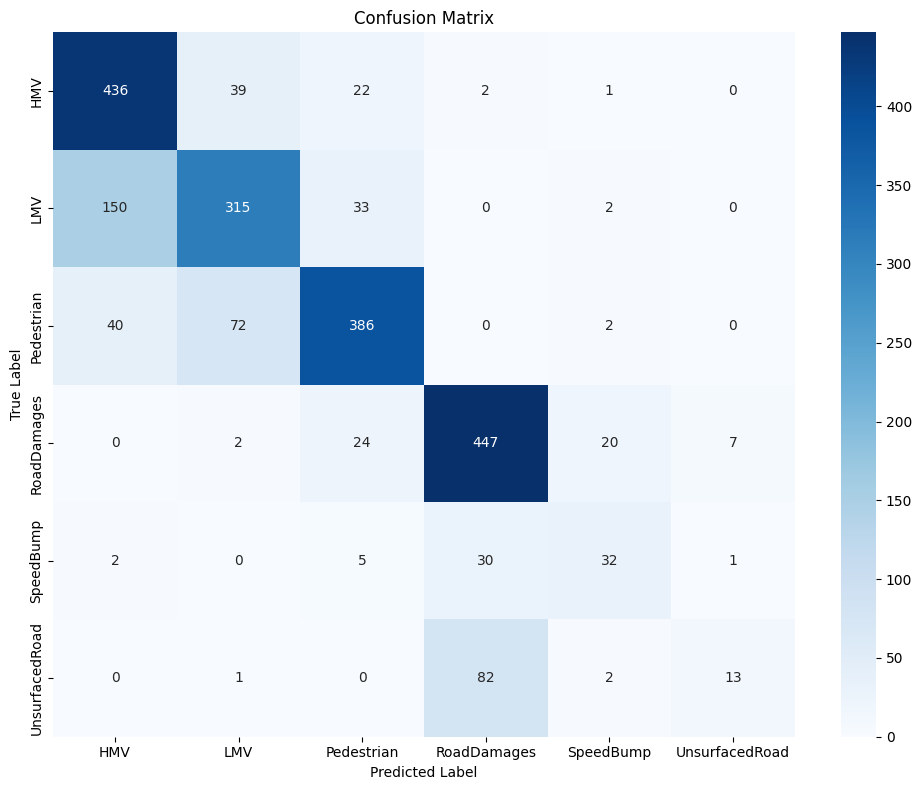

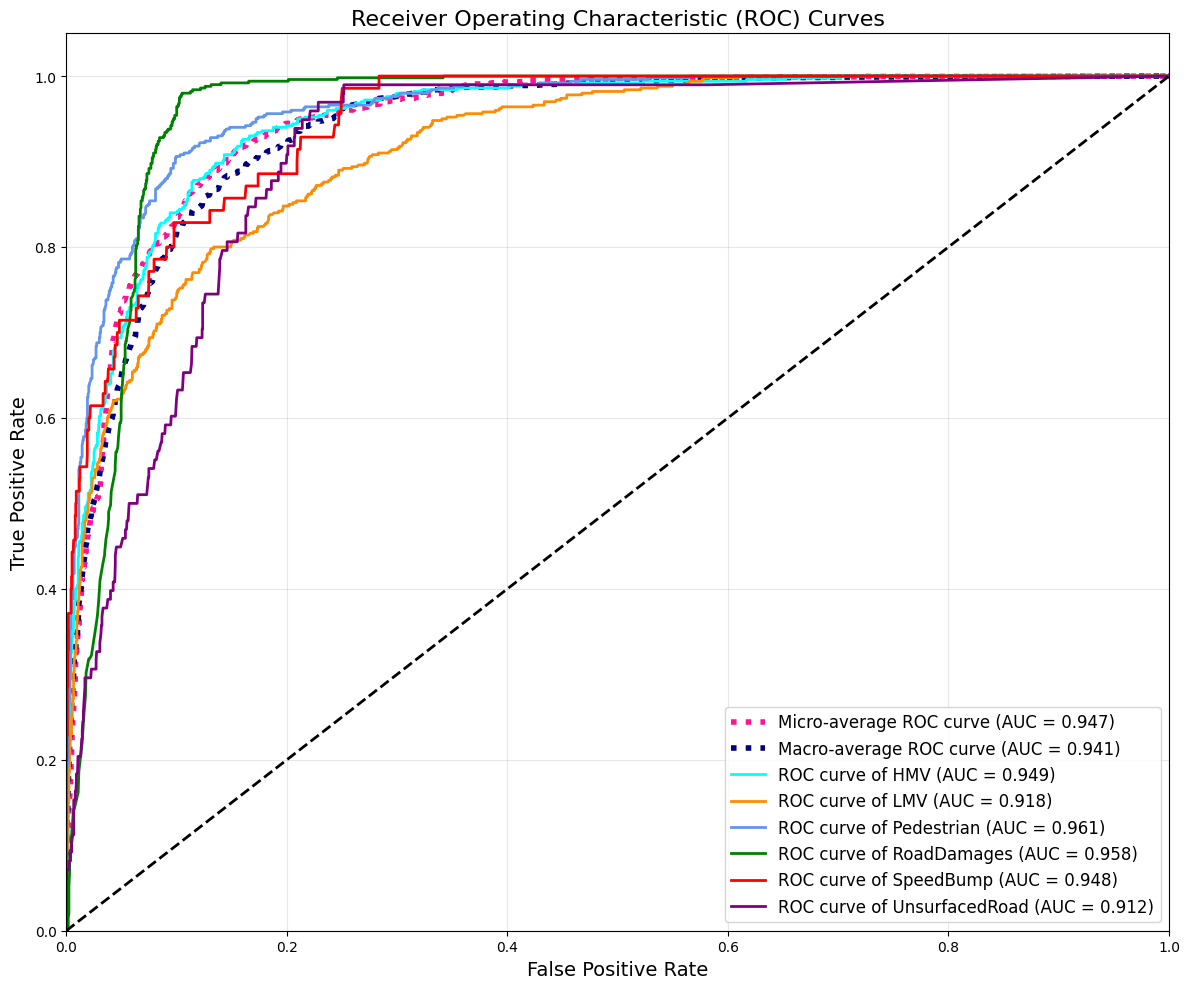


AUC scores for each class:
HMV: 0.9485
LMV: 0.9182
Pedestrian: 0.9607
RoadDamages: 0.9579
SpeedBump: 0.9479
UnsurfacedRoad: 0.9121
Micro-average AUC: 0.9468
Macro-average AUC: 0.9410


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
from tqdm import tqdm
from itertools import cycle

# Clear TensorFlow session at the beginning
tf.keras.backend.clear_session()

# Set path to organized dataset
DATASET_PATH = '/content/dataset/kaggle/working/organized_dataset'

# Set constants - optimized for memory efficiency
IMG_HEIGHT = 160  # Reduced from 224
IMG_WIDTH = 160   # Reduced from 224
BATCH_SIZE = 8    # Small batch size to save memory
EPOCHS = 30       # Increased as requested
CLASS_NAMES = ['HMV', 'LMV', 'Pedestrian', 'RoadDamages', 'SpeedBump', 'UnsurfacedRoad']
NUM_CLASSES = len(CLASS_NAMES)

# Configure TensorFlow to be memory efficient
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Found {len(gpus)} GPU(s)")
    try:
        # Limit GPU memory usage
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # 4GB limit
            )
        print("GPU memory limit set to 4GB")
    except RuntimeError as e:
        # Configuration must be set before GPUs have been initialized
        print(f"GPU configuration error: {e}")

# Enable mixed precision training to save memory
try:
    from tensorflow.keras.mixed_precision import set_global_policy
    set_global_policy('mixed_float16')
    print("Mixed precision training enabled (float16)")
except:
    print("Could not enable mixed precision training")

# Create data generators with augmentation for training
def create_data_generators():
    # Training data with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Validation and test data only get rescaled
    val_test_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Create generators
    train_dir = os.path.join(DATASET_PATH, 'train')
    val_dir = os.path.join(DATASET_PATH, 'valid')
    test_dir = os.path.join(DATASET_PATH, 'test')

    # Check if directories exist
    train_exists = os.path.exists(train_dir)
    val_exists = os.path.exists(val_dir)
    test_exists = os.path.exists(test_dir)

    if not train_exists:
        print(f"Warning: Training directory not found at {train_dir}")

    # Training generator
    train_generator = None
    train_samples = 0
    if train_exists:
        print(f"Creating training generator from {train_dir}")
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            classes=CLASS_NAMES,
            shuffle=True
        )
        train_samples = train_generator.samples
        print(f"Found {train_samples} training images in {len(train_generator.class_indices)} classes")

    # Validation generator
    val_generator = None
    val_samples = 0
    if val_exists:
        print(f"Creating validation generator from {val_dir}")
        val_generator = val_test_datagen.flow_from_directory(
            val_dir,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            classes=CLASS_NAMES,
            shuffle=False
        )
        val_samples = val_generator.samples
        print(f"Found {val_samples} validation images")

    # Test generator
    test_generator = None
    test_samples = 0
    if test_exists:
        print(f"Creating test generator from {test_dir}")
        test_generator = val_test_datagen.flow_from_directory(
            test_dir,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            classes=CLASS_NAMES,
            shuffle=False
        )
        test_samples = test_generator.samples
        print(f"Found {test_samples} test images")

    return train_generator, val_generator, test_generator, train_samples, val_samples, test_samples

# Create ResNet50 model with properly initialized weights
def build_resnet50_model():
    # Create base model with pre-trained weights and without the classification layers
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Create the complete model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

# Function to train model in two phases (transfer learning)
def train_resnet50_model():
    # Create data generators
    train_generator, val_generator, test_generator, train_samples, val_samples, test_samples = create_data_generators()

    if train_generator is None or train_samples == 0:
        print("No training data found. Exiting.")
        return

    # Calculate steps
    steps_per_epoch = train_samples // BATCH_SIZE
    validation_steps = val_samples // BATCH_SIZE if val_samples > 0 else None

    # Build model
    print("\nBuilding ResNet50 model...")
    model, base_model = build_resnet50_model()
    model.summary()

    # Callbacks
    checkpoint = ModelCheckpoint(
        'best_resnet50_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )

    callbacks = [checkpoint, early_stopping, reduce_lr]

    # Phase 1: Train only the classification head
    print("\nPhase 1: Training only the classification head...")
    history1 = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS // 2,  # First half of epochs for phase 1
        validation_data=val_generator if val_samples > 0 else None,
        validation_steps=validation_steps,
        callbacks=callbacks
    )

    # Phase 2: Fine-tune the model by unfreezing some layers
    print("\nPhase 2: Fine-tuning the model...")

    # Unfreeze the last few blocks of ResNet50
    # ResNet50 has 5 stages, so we'll unfreeze the last stage
    for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
        layer.trainable = True

    # Recompile with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Continue training
    history2 = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS // 2,  # Second half of epochs for phase 2
        validation_data=val_generator if val_samples > 0 else None,
        validation_steps=validation_steps,
        callbacks=callbacks
    )

    # Save final model
    model.save('final_resnet50_model.keras')
    print("Model saved to final_resnet50_model.keras")

    # Combine histories
    combined_history = {}
    for k in history1.history.keys():
        combined_history[k] = history1.history[k] + history2.history[k]

    # Plot training history
    plot_training_history(combined_history, val_samples > 0)

    # Evaluate on test set
    if test_generator is not None and test_samples > 0:
        evaluate_model(model, test_generator, test_samples)
    else:
        print("No test data available for evaluation")

# Plot training history
def plot_training_history(history, has_validation):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    if has_validation:
        plt.plot(history['val_accuracy'])
        plt.legend(['Train', 'Validation'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    if has_validation:
        plt.plot(history['val_loss'])
        plt.legend(['Train', 'Validation'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.tight_layout()
    plt.savefig('resnet50_training_history.png')
    plt.show()
    plt.close()  # Close figure to free memory

# Plot ROC curves
def plot_roc_curves(y_true, y_pred_proba, class_names):
    """
    Plot ROC curves and calculate AUC for multi-class classification.
    """
    n_classes = len(class_names)

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Calculate ROC curve and AUC for each class
    for i in range(n_classes):
        # For each class, calculate the ROC curve using one-vs-rest approach
        class_true = (y_true == i).astype(int)
        class_score = y_pred_proba[:, i]

        fpr[i], tpr[i], _ = roc_curve(class_true, class_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calculate macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    macro_roc_auc = auc(all_fpr, mean_tpr)

    # Calculate micro-average ROC curve and AUC
    # Flatten predictions and true values
    y_true_flatten = np.zeros((y_true.size, n_classes))
    for i in range(n_classes):
        y_true_flatten[:, i] = (y_true == i)

    y_pred_flatten = y_pred_proba.ravel()
    y_true_flatten = y_true_flatten.ravel()

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_flatten, y_pred_flatten)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(12, 10))

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.3f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Plot macro-average ROC curve
    plt.plot(all_fpr, mean_tpr,
             label=f'Macro-average ROC curve (AUC = {macro_roc_auc:.3f})',
             color='navy', linestyle=':', linewidth=4)

    # Plot ROC curves for all classes
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.3f})')

    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('resnet50_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Print AUC scores for each class
    print("\nAUC scores for each class:")
    for i in range(n_classes):
        print(f"{class_names[i]}: {roc_auc[i]:.4f}")

    print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average AUC: {macro_roc_auc:.4f}")

    return roc_auc

# Evaluate model on test set
def evaluate_model(model, test_generator, test_samples):
    print("\nEvaluating on test set...")

    # Reset generator
    test_generator.reset()

    # Evaluate model
    test_loss, test_acc = model.evaluate(test_generator, steps=test_samples//BATCH_SIZE)
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Generate predictions
    test_generator.reset()
    steps = (test_samples // BATCH_SIZE) + (1 if test_samples % BATCH_SIZE > 0 else 0)

    # Collect true labels and predictions
    y_true = []
    y_pred = []
    y_pred_proba = []  # Store probabilities for ROC curve

    for i in tqdm(range(steps), desc="Generating predictions"):
        x_batch, y_batch = next(test_generator)

        # If we're at the last batch and it's not a full batch
        if i == steps - 1 and test_samples % BATCH_SIZE > 0:
            # Only predict on the actual number of samples in this batch
            actual_batch_size = test_samples % BATCH_SIZE
            batch_preds = model.predict(x_batch[:actual_batch_size])
            batch_true = y_batch[:actual_batch_size]
        else:
            batch_preds = model.predict(x_batch)
            batch_true = y_batch

        # Convert one-hot encoded labels back to class indices
        batch_pred_classes = np.argmax(batch_preds, axis=1)
        batch_true_classes = np.argmax(batch_true, axis=1)

        y_true.extend(batch_true_classes)
        y_pred.extend(batch_pred_classes)
        y_pred_proba.append(batch_preds)

        # Free memory
        del x_batch, y_batch

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_proba = np.vstack(y_pred_proba)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    precision_class = precision_score(y_true, y_pred, average=None)
    recall_class = recall_score(y_true, y_pred, average=None)
    f1_class = f1_score(y_true, y_pred, average=None)

    # Print comprehensive evaluation metrics
    print("\n===== COMPREHENSIVE EVALUATION METRICS =====")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nWeighted Metrics (accounts for class imbalance):")
    print(f"Weighted Precision: {precision_weighted:.4f}")
    print(f"Weighted Recall: {recall_weighted:.4f}")
    print(f"Weighted F1-score: {f1_weighted:.4f}")

    print("\nPer-class Metrics:")
    print("Class               Precision    Recall       F1-Score")
    print("-" * 60)
    for i, class_name in enumerate(CLASS_NAMES):
        print(f"{class_name:<18} {precision_class[i]:.4f}       {recall_class[i]:.4f}       {f1_class[i]:.4f}")

    # Classification report (includes precision, recall, f1-score, support)
    print("\nDetailed Classification Report:")
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
    print(report)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('resnet50_confusion_matrix.png')
    plt.show()
    plt.close()  # Close figure to free memory

    # Plot ROC curves
    plot_roc_curves(y_true, y_pred_proba, CLASS_NAMES)

if __name__ == "__main__":
    # Print TensorFlow version
    print(f"TensorFlow version: {tf.__version__}")

    # Check for GPU availability
    print("GPU Available: ", tf.config.list_physical_devices('GPU'))

    # Start training
    train_resnet50_model()

Found 1 GPU(s)
GPU memory limit set to 4GB
Mixed precision training enabled (float16)
TensorFlow version: 2.18.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Creating training generator from /content/dataset/kaggle/working/organized_dataset/train
Found 2751 images belonging to 6 classes.
Found 2751 training images in 6 classes
Creating validation generator from /content/dataset/kaggle/working/organized_dataset/valid
Found 2173 images belonging to 6 classes.
Found 2173 validation images
Creating test generator from /content/dataset/kaggle/working/organized_dataset/test
Found 2168 images belonging to 6 classes.
Found 2168 test images

Building EfficientNetB0 model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 160, 160,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 160, 160,  │          0 │ cast[0][0]        │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 160, 160,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 160, 160,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 161, 161,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 80, 80,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 80, 80,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 80, 80,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 80, 80,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 80, 80,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 80, 80,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 80, 80,    │          0 │ block1a_activati

 Total params: 4,838,313 (18.46 MB)

 Trainable params: 788,742 (3.01 MB)

 Non-trainable params: 4,049,571 (15.45 MB)


Phase 1: Training only the classification head...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


343/343 ━━━━━━━━━━━━━━━━━━━━ 74s 137ms/step - accuracy: 0.1996 - loss: 1.9010 - val_accuracy: 0.2306 - val_loss: 1.7736 - learning_rate: 0.0010
Epoch 2/15
  1/343 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.2500 - loss: 1.7764

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


343/343 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2500 - loss: 1.7764 - val_accuracy: 0.2306 - val_loss: 1.7735 - learning_rate: 0.0010
Epoch 3/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.1662 - loss: 1.7863 - val_accuracy: 0.2306 - val_loss: 1.7427 - learning_rate: 0.0010
Epoch 4/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1250 - loss: 1.7676 - val_accuracy: 0.2306 - val_loss: 1.7426 - learning_rate: 0.0010
Epoch 5/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.1725 - loss: 1.7865 - val_accuracy: 0.2306 - val_loss: 1.7316 - learning_rate: 0.0010
Epoch 6/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1250 - loss: 1.8784 - val_accuracy: 0.2306 - val_loss: 1.7316 - learning_rate: 0.0010
Epoch 7/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.1871 - loss: 1.7828 - val_accuracy: 0.2306 - val_loss: 1.7279 - learning_rate: 0.0010
Epoch 8/15
343/343 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3750 - loss: 1.7626 - v

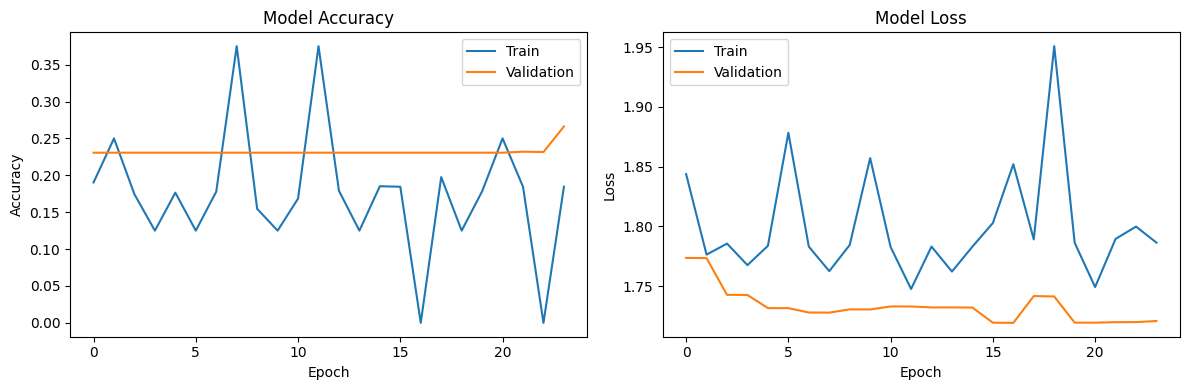


Evaluating on test set...
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.0513 - loss: 1.6939
Test accuracy: 0.2306
Test loss: 1.7182


Generating predictions:   0%|          | 0/271 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


Generating predictions:   0%|          | 1/271 [00:10<46:20, 10.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:   1%|          | 2/271 [00:10<19:20,  4.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:   1%|          | 3/271 [00:10<10:41,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:   2%|▏         | 5/271 [00:10<04:50,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:   3%|▎         | 7/271 [00:10<02:50,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:   3%|▎         | 9/271 [00:11<01:52,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:   4%|▍         | 11/271 [00:11<01:22,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:   4%|▍         | 12/271 [00:11<01:12,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Generating predictions:   5%|▍         | 13/271 [00:11<01:01,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:   6%|▌         | 15/271 [00:11<00:46,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:   6%|▌         | 16/271 [00:11<00:42,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:   6%|▋         | 17/271 [00:11<00:40,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:   7%|▋         | 18/271 [00:12<00:37,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:   7%|▋         | 19/271 [00:12<00:35,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:   7%|▋         | 20/271 [00:12<00:34,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:   8%|▊         | 22/271 [00:12<00:30,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:   9%|▉         | 24/271 [00:12<00:27,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  10%|▉         | 26/271 [00:12<00:26,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  10%|█         | 28/271 [00:13<00:25,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  11%|█         | 29/271 [00:13<00:26,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  11%|█         | 30/271 [00:13<00:26,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:  11%|█▏        | 31/271 [00:13<00:27,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Generating predictions:  12%|█▏        | 32/271 [00:13<00:28,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Generating predictions:  13%|█▎        | 34/271 [00:13<00:24,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:  13%|█▎        | 35/271 [00:13<00:25,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  13%|█▎        | 36/271 [00:14<00:25,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  14%|█▍        | 38/271 [00:14<00:24,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:  14%|█▍        | 39/271 [00:14<00:25,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  15%|█▌        | 41/271 [00:14<00:23,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  15%|█▌        | 42/271 [00:14<00:25,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Generating predictions:  16%|█▌        | 43/271 [00:14<00:25,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:  17%|█▋        | 45/271 [00:14<00:22,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  17%|█▋        | 46/271 [00:15<00:23,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  17%|█▋        | 47/271 [00:15<00:24,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  18%|█▊        | 48/271 [00:15<00:25,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  18%|█▊        | 50/271 [00:15<00:22,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  19%|█▉        | 51/271 [00:15<00:23,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  19%|█▉        | 52/271 [00:15<00:24,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:  20%|█▉        | 54/271 [00:15<00:22,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  20%|██        | 55/271 [00:16<00:22,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  21%|██        | 57/271 [00:16<00:21, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  21%|██▏       | 58/271 [00:16<00:22,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  22%|██▏       | 59/271 [00:16<00:23,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  22%|██▏       | 60/271 [00:16<00:23,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  23%|██▎       | 61/271 [00:16<00:22,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  23%|██▎       | 62/271 [00:16<00:23,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  24%|██▎       | 64/271 [00:17<00:22,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  24%|██▍       | 65/271 [00:17<00:23,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  24%|██▍       | 66/271 [00:17<00:23,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  25%|██▌       | 68/271 [00:17<00:22,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  25%|██▌       | 69/271 [00:17<00:23,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Generating predictions:  26%|██▌       | 70/271 [00:17<00:23,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Generating predictions:  26%|██▌       | 71/271 [00:17<00:25,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  27%|██▋       | 72/271 [00:18<00:26,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Generating predictions:  27%|██▋       | 73/271 [00:18<00:25,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  27%|██▋       | 74/271 [00:18<00:26,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Generating predictions:  28%|██▊       | 75/271 [00:18<00:26,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  28%|██▊       | 76/271 [00:18<00:25,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Generating predictions:  28%|██▊       | 77/271 [00:18<00:25,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Generating predictions:  29%|██▉       | 78/271 [00:18<00:27,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  29%|██▉       | 79/271 [00:19<00:27,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Generating predictions:  30%|██▉       | 80/271 [00:19<00:28,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Generating predictions:  30%|██▉       | 81/271 [00:19<00:27,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  30%|███       | 82/271 [00:19<00:26,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Generating predictions:  31%|███       | 83/271 [00:19<00:26,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  31%|███       | 84/271 [00:19<00:26,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Generating predictions:  31%|███▏      | 85/271 [00:19<00:27,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Generating predictions:  32%|███▏      | 86/271 [00:20<00:26,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Generating predictions:  32%|███▏      | 87/271 [00:20<00:25,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  32%|███▏      | 88/271 [00:20<00:24,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  33%|███▎      | 89/271 [00:20<00:23,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Generating predictions:  33%|███▎      | 90/271 [00:20<00:24,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Generating predictions:  34%|███▎      | 91/271 [00:20<00:24,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Generating predictions:  34%|███▍      | 92/271 [00:20<00:25,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Generating predictions:  34%|███▍      | 93/271 [00:20<00:25,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Generating predictions:  35%|███▍      | 94/271 [00:21<00:25,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  35%|███▌      | 95/271 [00:21<00:23,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Generating predictions:  36%|███▌      | 97/271 [00:21<00:19,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  36%|███▌      | 98/271 [00:21<00:19,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  37%|███▋      | 99/271 [00:21<00:19,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  37%|███▋      | 100/271 [00:21<00:20,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  37%|███▋      | 101/271 [00:21<00:20,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:  38%|███▊      | 102/271 [00:22<00:20,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  38%|███▊      | 103/271 [00:22<00:20,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  38%|███▊      | 104/271 [00:22<00:20,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:  39%|███▉      | 106/271 [00:22<00:17,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:  39%|███▉      | 107/271 [00:22<00:18,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  40%|████      | 109/271 [00:22<00:16,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  41%|████      | 110/271 [00:22<00:17,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  41%|████      | 111/271 [00:23<00:17,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  42%|████▏     | 113/271 [00:23<00:17,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  42%|████▏     | 114/271 [00:23<00:17,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  43%|████▎     | 116/271 [00:23<00:16,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  43%|████▎     | 117/271 [00:23<00:17,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:  44%|████▍     | 119/271 [00:23<00:16,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  44%|████▍     | 120/271 [00:24<00:16,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  45%|████▍     | 121/271 [00:24<00:17,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  45%|████▌     | 123/271 [00:24<00:15,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  46%|████▌     | 124/271 [00:24<00:15,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  46%|████▌     | 125/271 [00:24<00:16,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  46%|████▋     | 126/271 [00:24<00:16,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  47%|████▋     | 127/271 [00:24<00:16,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  47%|████▋     | 128/271 [00:24<00:16,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  48%|████▊     | 130/271 [00:25<00:16,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  49%|████▊     | 132/271 [00:25<00:15,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  49%|████▉     | 134/271 [00:25<00:14,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  50%|█████     | 136/271 [00:25<00:14,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  51%|█████     | 137/271 [00:25<00:14,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  51%|█████     | 138/271 [00:26<00:15,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Generating predictions:  51%|█████▏    | 139/271 [00:26<00:15,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  52%|█████▏    | 140/271 [00:26<00:15,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  52%|█████▏    | 141/271 [00:26<00:15,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  52%|█████▏    | 142/271 [00:26<00:15,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  53%|█████▎    | 144/271 [00:26<00:14,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  54%|█████▎    | 145/271 [00:26<00:14,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  54%|█████▍    | 147/271 [00:27<00:13,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Generating predictions:  55%|█████▍    | 148/271 [00:27<00:13,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  55%|█████▍    | 149/271 [00:27<00:13,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  55%|█████▌    | 150/271 [00:27<00:13,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  56%|█████▌    | 151/271 [00:27<00:14,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  56%|█████▋    | 153/271 [00:27<00:13,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  57%|█████▋    | 155/271 [00:27<00:11,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  58%|█████▊    | 156/271 [00:28<00:12,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  58%|█████▊    | 158/271 [00:28<00:12,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  59%|█████▊    | 159/271 [00:28<00:12,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  59%|█████▉    | 160/271 [00:28<00:12,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  59%|█████▉    | 161/271 [00:28<00:12,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Generating predictions:  60%|█████▉    | 162/271 [00:28<00:13,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  61%|██████    | 164/271 [00:28<00:11,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  61%|██████    | 165/271 [00:29<00:11,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  61%|██████▏   | 166/271 [00:29<00:11,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  62%|██████▏   | 167/271 [00:29<00:12,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  62%|██████▏   | 169/271 [00:29<00:11,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  63%|██████▎   | 170/271 [00:29<00:11,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  63%|██████▎   | 171/271 [00:29<00:11,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  63%|██████▎   | 172/271 [00:29<00:11,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  64%|██████▍   | 174/271 [00:30<00:10,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Generating predictions:  65%|██████▍   | 176/271 [00:30<00:10,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  65%|██████▌   | 177/271 [00:30<00:10,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  66%|██████▌   | 179/271 [00:30<00:09,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  66%|██████▋   | 180/271 [00:30<00:09,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  67%|██████▋   | 182/271 [00:30<00:09,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  68%|██████▊   | 183/271 [00:31<00:09,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  68%|██████▊   | 185/271 [00:31<00:09,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Generating predictions:  69%|██████▊   | 186/271 [00:31<00:09,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  69%|██████▉   | 187/271 [00:31<00:09,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions:  69%|██████▉   | 188/271 [00:31<00:10,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Generating predictions:  70%|██████▉   | 189/271 [00:31<00:10,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  70%|███████   | 190/271 [00:31<00:11,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions:  70%|███████   | 191/271 [00:32<00:10,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Generating predictions:  71%|███████   | 192/271 [00:32<00:11,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Generating predictions:  71%|███████   | 193/271 [00:32<00:10,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions:  72%|███████▏  | 194/271 [00:32<00:10,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Generating predictions:  72%|███████▏  | 195/271 [00:32<00:10,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Generating predictions:  72%|███████▏  | 196/271 [00:32<00:10,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  73%|███████▎  | 197/271 [00:32<00:10,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Generating predictions:  73%|███████▎  | 198/271 [00:33<00:10,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Generating predictions:  73%|███████▎  | 199/271 [00:33<00:10,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Generating predictions:  74%|███████▍  | 200/271 [00:33<00:10,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  74%|███████▍  | 201/271 [00:33<00:10,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Generating predictions:  75%|███████▍  | 202/271 [00:33<00:10,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Generating predictions:  75%|███████▍  | 203/271 [00:33<00:09,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Generating predictions:  75%|███████▌  | 204/271 [00:33<00:10,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Generating predictions:  76%|███████▌  | 205/271 [00:34<00:10,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Generating predictions:  76%|███████▌  | 206/271 [00:34<00:09,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Generating predictions:  76%|███████▋  | 207/271 [00:34<00:09,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Generating predictions:  77%|███████▋  | 208/271 [00:34<00:09,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  77%|███████▋  | 210/271 [00:34<00:07,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  78%|███████▊  | 211/271 [00:34<00:07,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  78%|███████▊  | 212/271 [00:35<00:07,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  79%|███████▉  | 214/271 [00:35<00:06,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  80%|███████▉  | 216/271 [00:35<00:05,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  80%|████████  | 217/271 [00:35<00:05,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  81%|████████  | 219/271 [00:35<00:05,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  81%|████████  | 220/271 [00:35<00:05,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  82%|████████▏ | 221/271 [00:35<00:05,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  82%|████████▏ | 223/271 [00:36<00:05,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  83%|████████▎ | 224/271 [00:36<00:05,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  83%|████████▎ | 225/271 [00:36<00:05,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  83%|████████▎ | 226/271 [00:36<00:05,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  84%|████████▍ | 227/271 [00:36<00:05,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  84%|████████▍ | 228/271 [00:36<00:05,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  85%|████████▍ | 229/271 [00:36<00:05,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  85%|████████▌ | 231/271 [00:37<00:04,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  86%|████████▌ | 232/271 [00:37<00:04,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  86%|████████▋ | 234/271 [00:37<00:03,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Generating predictions:  87%|████████▋ | 235/271 [00:37<00:03,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Generating predictions:  87%|████████▋ | 236/271 [00:37<00:04,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  87%|████████▋ | 237/271 [00:37<00:03,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  88%|████████▊ | 238/271 [00:37<00:03,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  89%|████████▊ | 240/271 [00:38<00:03,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  89%|████████▉ | 241/271 [00:38<00:03,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  90%|████████▉ | 243/271 [00:38<00:03,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Generating predictions:  90%|█████████ | 245/271 [00:38<00:02,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  91%|█████████ | 246/271 [00:38<00:02,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  91%|█████████ | 247/271 [00:38<00:02,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  92%|█████████▏| 249/271 [00:39<00:02,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  93%|█████████▎| 251/271 [00:39<00:02,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Generating predictions:  93%|█████████▎| 253/271 [00:39<00:01,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions:  94%|█████████▎| 254/271 [00:39<00:01,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  94%|█████████▍| 255/271 [00:39<00:01,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Generating predictions:  94%|█████████▍| 256/271 [00:39<00:01,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  95%|█████████▍| 257/271 [00:40<00:01,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Generating predictions:  95%|█████████▌| 258/271 [00:40<00:01,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  96%|█████████▌| 259/271 [00:40<00:01,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  96%|█████████▋| 261/271 [00:40<00:01,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Generating predictions:  97%|█████████▋| 262/271 [00:40<00:01,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Generating predictions:  97%|█████████▋| 263/271 [00:40<00:00,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Generating predictions:  98%|█████████▊| 265/271 [00:40<00:00,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  98%|█████████▊| 266/271 [00:41<00:00,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  99%|█████████▊| 267/271 [00:41<00:00,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Generating predictions:  99%|█████████▉| 269/271 [00:41<00:00,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Generating predictions: 100%|██████████| 271/271 [00:41<00:00,  6.52it/s]


===== COMPREHENSIVE EVALUATION METRICS =====
Overall Accuracy: 0.2306

Weighted Metrics (accounts for class imbalance):
Weighted Precision: 0.0532
Weighted Recall: 0.2306
Weighted F1-score: 0.0864

Per-class Metrics:
Class               Precision    Recall       F1-Score
------------------------------------------------------------
HMV                0.0000       0.0000       0.0000
LMV                0.0000       0.0000       0.0000
Pedestrian         0.0000       0.0000       0.0000
RoadDamages        0.2306       1.0000       0.3748
SpeedBump          0.0000       0.0000       0.0000
UnsurfacedRoad     0.0000       0.0000       0.0000

Detailed Classification Report:
                precision    recall  f1-score   support

           HMV       0.00      0.00      0.00       500
           LMV       0.00      0.00      0.00       500
    Pedestrian       0.00      0.00      0.00       500
   RoadDamages       0.23      1.00      0.37       500
     SpeedBump       0.00      0.00     


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/

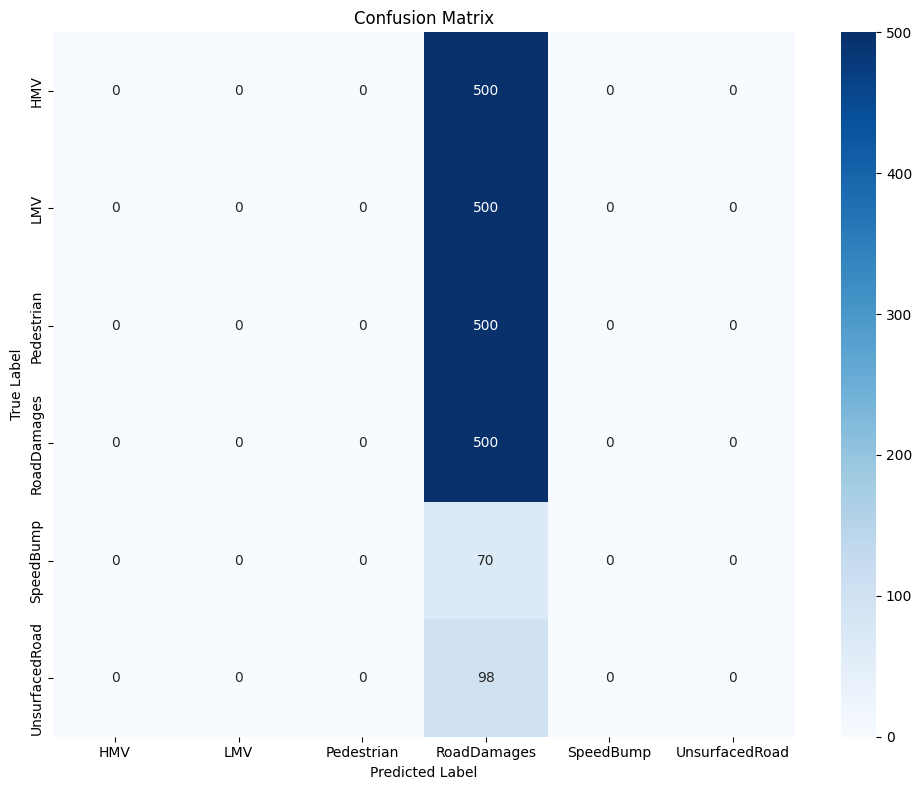

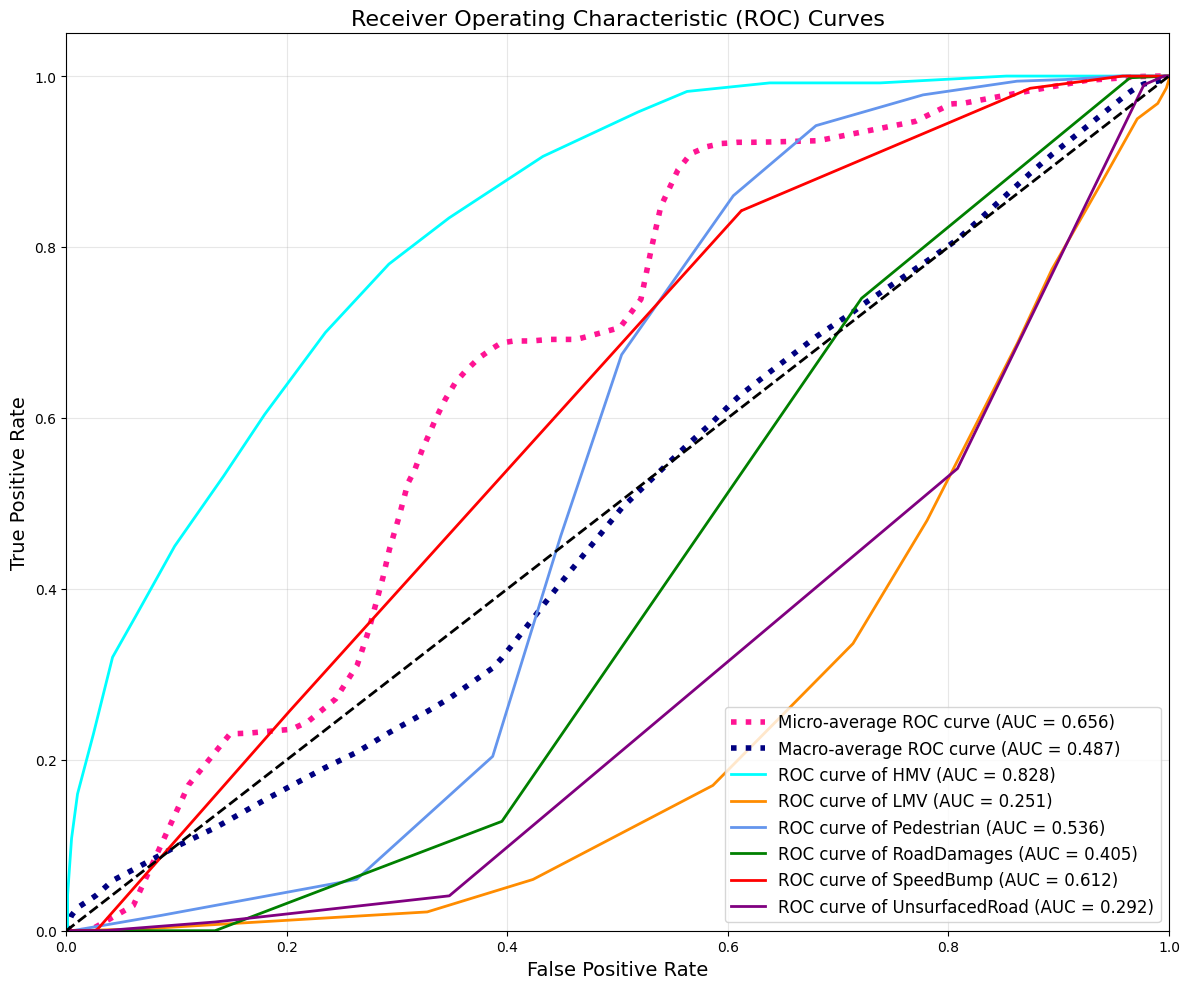


AUC scores for each class:
HMV: 0.8281
LMV: 0.2506
Pedestrian: 0.5358
RoadDamages: 0.4051
SpeedBump: 0.6125
UnsurfacedRoad: 0.2920
Micro-average AUC: 0.6555
Macro-average AUC: 0.4873


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
from tqdm import tqdm
from itertools import cycle

# Clear TensorFlow session at the beginning
tf.keras.backend.clear_session()

# Set path to organized dataset
DATASET_PATH = '/content/dataset/kaggle/working/organized_dataset'

# Set constants - optimized for memory efficiency
IMG_HEIGHT = 160  # Reduced from 224
IMG_WIDTH = 160   # Reduced from 224
BATCH_SIZE = 8    # Small batch size to save memory
EPOCHS = 30       # Increased as requested
CLASS_NAMES = ['HMV', 'LMV', 'Pedestrian', 'RoadDamages', 'SpeedBump', 'UnsurfacedRoad']
NUM_CLASSES = len(CLASS_NAMES)

# Configure TensorFlow to be memory efficient
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Found {len(gpus)} GPU(s)")
    try:
        # Limit GPU memory usage
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # 4GB limit
            )
        print("GPU memory limit set to 4GB")
    except RuntimeError as e:
        # Configuration must be set before GPUs have been initialized
        print(f"GPU configuration error: {e}")

# Enable mixed precision training to save memory
try:
    from tensorflow.keras.mixed_precision import set_global_policy
    set_global_policy('mixed_float16')
    print("Mixed precision training enabled (float16)")
except:
    print("Could not enable mixed precision training")

# Create data generators with augmentation for training
def create_data_generators():
    # Training data with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Validation and test data only get rescaled
    val_test_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Create generators
    train_dir = os.path.join(DATASET_PATH, 'train')
    val_dir = os.path.join(DATASET_PATH, 'valid')
    test_dir = os.path.join(DATASET_PATH, 'test')

    # Check if directories exist
    train_exists = os.path.exists(train_dir)
    val_exists = os.path.exists(val_dir)
    test_exists = os.path.exists(test_dir)

    if not train_exists:
        print(f"Warning: Training directory not found at {train_dir}")

    # Training generator
    train_generator = None
    train_samples = 0
    if train_exists:
        print(f"Creating training generator from {train_dir}")
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            classes=CLASS_NAMES,
            shuffle=True
        )
        train_samples = train_generator.samples
        print(f"Found {train_samples} training images in {len(train_generator.class_indices)} classes")

    # Validation generator
    val_generator = None
    val_samples = 0
    if val_exists:
        print(f"Creating validation generator from {val_dir}")
        val_generator = val_test_datagen.flow_from_directory(
            val_dir,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            classes=CLASS_NAMES,
            shuffle=False
        )
        val_samples = val_generator.samples
        print(f"Found {val_samples} validation images")

    # Test generator
    test_generator = None
    test_samples = 0
    if test_exists:
        print(f"Creating test generator from {test_dir}")
        test_generator = val_test_datagen.flow_from_directory(
            test_dir,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            classes=CLASS_NAMES,
            shuffle=False
        )
        test_samples = test_generator.samples
        print(f"Found {test_samples} test images")

    return train_generator, val_generator, test_generator, train_samples, val_samples, test_samples

# Create EfficientNetB0 model with properly initialized weights
def build_efficientnet_model():
    # Create base model with pre-trained weights and without the classification layers
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Create the complete model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

# Function to train model in two phases (transfer learning)
def train_efficientnet_model():
    # Create data generators
    train_generator, val_generator, test_generator, train_samples, val_samples, test_samples = create_data_generators()

    if train_generator is None or train_samples == 0:
        print("No training data found. Exiting.")
        return

    # Calculate steps
    steps_per_epoch = train_samples // BATCH_SIZE
    validation_steps = val_samples // BATCH_SIZE if val_samples > 0 else None

    # Build model
    print("\nBuilding EfficientNetB0 model...")
    model, base_model = build_efficientnet_model()
    model.summary()

    # Callbacks
    checkpoint = ModelCheckpoint(
        'best_efficientnet_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )

    callbacks = [checkpoint, early_stopping, reduce_lr]

    # Phase 1: Train only the classification head
    print("\nPhase 1: Training only the classification head...")
    history1 = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS // 2,  # First half of epochs for phase 1
        validation_data=val_generator if val_samples > 0 else None,
        validation_steps=validation_steps,
        callbacks=callbacks
    )

    # Phase 2: Fine-tune the model by unfreezing some layers
    print("\nPhase 2: Fine-tuning the model...")

    # Unfreeze the last few blocks of EfficientNet
    # EfficientNetB0 has 7 blocks, so we'll unfreeze just the last block
    for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
        layer.trainable = True

    # Recompile with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Continue training
    history2 = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS // 2,  # Second half of epochs for phase 2
        validation_data=val_generator if val_samples > 0 else None,
        validation_steps=validation_steps,
        callbacks=callbacks
    )

    # Save final model
    model.save('final_efficientnet_model.keras')
    print("Model saved to final_efficientnet_model.keras")

    # Combine histories
    combined_history = {}
    for k in history1.history.keys():
        combined_history[k] = history1.history[k] + history2.history[k]

    # Plot training history
    plot_training_history(combined_history, val_samples > 0)

    # Evaluate on test set
    if test_generator is not None and test_samples > 0:
        evaluate_model(model, test_generator, test_samples)
    else:
        print("No test data available for evaluation")

# Plot training history
def plot_training_history(history, has_validation):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    if has_validation:
        plt.plot(history['val_accuracy'])
        plt.legend(['Train', 'Validation'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    if has_validation:
        plt.plot(history['val_loss'])
        plt.legend(['Train', 'Validation'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.tight_layout()
    plt.savefig('efficientnet_training_history.png')
    plt.show()
    plt.close()  # Close figure to free memory

# Plot ROC curves
def plot_roc_curves(y_true, y_pred_proba, class_names):
    """
    Plot ROC curves and calculate AUC for multi-class classification.
    """
    n_classes = len(class_names)

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Calculate ROC curve and AUC for each class
    for i in range(n_classes):
        # For each class, calculate the ROC curve using one-vs-rest approach
        class_true = (y_true == i).astype(int)
        class_score = y_pred_proba[:, i]

        fpr[i], tpr[i], _ = roc_curve(class_true, class_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calculate macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    macro_roc_auc = auc(all_fpr, mean_tpr)

    # Calculate micro-average ROC curve and AUC
    # Flatten predictions and true values
    y_true_flatten = np.zeros((y_true.size, n_classes))
    for i in range(n_classes):
        y_true_flatten[:, i] = (y_true == i)

    y_pred_flatten = y_pred_proba.ravel()
    y_true_flatten = y_true_flatten.ravel()

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_flatten, y_pred_flatten)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(12, 10))

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.3f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Plot macro-average ROC curve
    plt.plot(all_fpr, mean_tpr,
             label=f'Macro-average ROC curve (AUC = {macro_roc_auc:.3f})',
             color='navy', linestyle=':', linewidth=4)

    # Plot ROC curves for all classes
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.3f})')

    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('efficientnet_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Print AUC scores for each class
    print("\nAUC scores for each class:")
    for i in range(n_classes):
        print(f"{class_names[i]}: {roc_auc[i]:.4f}")

    print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average AUC: {macro_roc_auc:.4f}")

    return roc_auc

# Evaluate model on test set
def evaluate_model(model, test_generator, test_samples):
    print("\nEvaluating on test set...")

    # Reset generator
    test_generator.reset()

    # Evaluate model
    test_loss, test_acc = model.evaluate(test_generator, steps=test_samples//BATCH_SIZE)
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Generate predictions
    test_generator.reset()
    steps = (test_samples // BATCH_SIZE) + (1 if test_samples % BATCH_SIZE > 0 else 0)

    # Collect true labels and predictions
    y_true = []
    y_pred = []
    y_pred_proba = []  # Store probabilities for ROC curve

    for i in tqdm(range(steps), desc="Generating predictions"):
        x_batch, y_batch = next(test_generator)

        # If we're at the last batch and it's not a full batch
        if i == steps - 1 and test_samples % BATCH_SIZE > 0:
            # Only predict on the actual number of samples in this batch
            actual_batch_size = test_samples % BATCH_SIZE
            batch_preds = model.predict(x_batch[:actual_batch_size])
            batch_true = y_batch[:actual_batch_size]
        else:
            batch_preds = model.predict(x_batch)
            batch_true = y_batch

        # Convert one-hot encoded labels back to class indices
        batch_pred_classes = np.argmax(batch_preds, axis=1)
        batch_true_classes = np.argmax(batch_true, axis=1)

        y_true.extend(batch_true_classes)
        y_pred.extend(batch_pred_classes)
        y_pred_proba.append(batch_preds)

        # Free memory
        del x_batch, y_batch

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_proba = np.vstack(y_pred_proba)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    precision_class = precision_score(y_true, y_pred, average=None)
    recall_class = recall_score(y_true, y_pred, average=None)
    f1_class = f1_score(y_true, y_pred, average=None)

    # Print comprehensive evaluation metrics
    print("\n===== COMPREHENSIVE EVALUATION METRICS =====")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nWeighted Metrics (accounts for class imbalance):")
    print(f"Weighted Precision: {precision_weighted:.4f}")
    print(f"Weighted Recall: {recall_weighted:.4f}")
    print(f"Weighted F1-score: {f1_weighted:.4f}")

    print("\nPer-class Metrics:")
    print("Class               Precision    Recall       F1-Score")
    print("-" * 60)
    for i, class_name in enumerate(CLASS_NAMES):
        print(f"{class_name:<18} {precision_class[i]:.4f}       {recall_class[i]:.4f}       {f1_class[i]:.4f}")

    # Classification report (includes precision, recall, f1-score, support)
    print("\nDetailed Classification Report:")
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
    print(report)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('efficientnet_confusion_matrix.png')
    plt.show()
    plt.close()  # Close figure to free memory

    # Plot ROC curves
    plot_roc_curves(y_true, y_pred_proba, CLASS_NAMES)

if __name__ == "__main__":
    # Print TensorFlow version
    print(f"TensorFlow version: {tf.__version__}")

    # Check for GPU availability
    print("GPU Available: ", tf.config.list_physical_devices('GPU'))

    # Start training
    train_efficientnet_model()

VGG16 + SHAP

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shap
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import time

# Direct paths from your dataset structure
TEST_PATHS = [
    '/content/dataset/kaggle/working/organized_dataset/test/HMV',
    '/content/dataset/kaggle/working/organized_dataset/test/LMV',
    '/content/dataset/kaggle/working/organized_dataset/test/Pedestrian',
    '/content/dataset/kaggle/working/organized_dataset/test/RoadDamages',
    '/content/dataset/kaggle/working/organized_dataset/test/SpeedBump',
    '/content/dataset/kaggle/working/organized_dataset/test/UnsurfacedRoad'
]

TRAIN_PATH = '/content/dataset/kaggle/working/organized_dataset/train'
VALID_PATH = '/content/dataset/kaggle/working/organized_dataset/valid'

# Constants
IMG_HEIGHT = 160
IMG_WIDTH = 160
BATCH_SIZE = 8
CLASS_NAMES = ['HMV', 'LMV', 'Pedestrian', 'RoadDamages', 'SpeedBump', 'UnsurfacedRoad']

# Global predict function that can be pickled
def global_predict_fn(images):
    return model.predict(images)

# Load your pre-trained model
MODEL_PATH = '/content/final_vgg16_model.keras'
print(f"Loading model from {MODEL_PATH}")
model = load_model(MODEL_PATH)

def load_images_from_folder(folder, num_samples=None):
    """Load images directly from a folder"""
    images = []
    datagen = ImageDataGenerator(rescale=1./255)

    print(f"Loading images from {folder}")
    generator = datagen.flow_from_directory(
        os.path.dirname(folder),  # Parent directory
        classes=[os.path.basename(folder)],
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=True
    )

    if num_samples:
        num_batches = int(np.ceil(num_samples/BATCH_SIZE))
        for i, batch in enumerate(generator):
            if i >= num_batches:
                break
            images.extend(batch)
        images = images[:num_samples]
    else:
        images = list(generator)

    return np.array(images)

def get_background_samples(num_samples=50):
    """Get balanced background samples from all classes"""
    background = []
    samples_per_class = max(1, num_samples // len(CLASS_NAMES))

    for class_name in CLASS_NAMES:
        class_path = os.path.join(TRAIN_PATH, class_name)
        if os.path.exists(class_path):
            class_images = load_images_from_folder(class_path, samples_per_class)
            background.extend(class_images)
        else:
            print(f"Warning: Class directory not found - {class_path}")

    background = np.array(background)[:num_samples]
    print(f"Collected {len(background)} background samples")
    return background

def create_shap_explainer(model, background):
    """Create SHAP explainer with optimized settings"""
    print("Creating SHAP explainer...")

    # Use the global predict function instead of local one
    explainer = shap.PartitionExplainer(
        global_predict_fn,
        shap.maskers.Image(background),
        output_names=CLASS_NAMES
    )

    return explainer

def explain_test_samples(explainer, num_samples=3):
    """Generate explanations for test samples from each class"""
    for class_path in TEST_PATHS:
        if not os.path.exists(class_path):
            print(f"Path not found: {class_path}")
            continue

        class_name = os.path.basename(class_path)
        print(f"\nGenerating explanations for class: {class_name}")

        # Load a few test samples
        test_images = load_images_from_folder(class_path, num_samples)

        if len(test_images) == 0:
            print("No test images found")
            continue

        # Compute SHAP values (use smaller max_evals for faster computation)
        try:
            shap_values = explainer(
                test_images,
                max_evals=200,
                silent=True
            )
        except Exception as e:
            print(f"Error generating SHAP values for {class_name}: {str(e)}")
            continue

        # Plot results
        for i in range(min(num_samples, len(test_images))):
            # Get prediction
            pred = model.predict(test_images[i:i+1])[0]
            pred_class = CLASS_NAMES[np.argmax(pred)]
            confidence = np.max(pred)

            # Plot original image
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(test_images[i])
            plt.title(f"True: {class_name}\nPredicted: {pred_class}\nConfidence: {confidence:.2f}")
            plt.axis('off')

            # Plot SHAP explanation
            plt.subplot(1, 2, 2)
            shap.image_plot(
                [shap_values[i]],
                [test_images[i]],
                show=False
            )
            plt.title("SHAP Explanation")
            plt.tight_layout()
            plt.show()

# Main execution
if __name__ == "__main__":
    # Load or create background samples
    bg_file = 'shap_background.pkl'
    if os.path.exists(bg_file):
        print("Loading background samples...")
        with open(bg_file, 'rb') as f:
            background = pickle.load(f)
    else:
        print("Creating new background samples...")
        background = get_background_samples(50)
        with open(bg_file, 'wb') as f:
            pickle.dump(background, f)

    # Note: We won't pickle the explainer anymore since it contains the model reference
    print("Creating SHAP explainer (not cached)...")
    explainer = create_shap_explainer(model, background)

    # Generate explanations
    explain_test_samples(explainer, num_samples=2)

Loading model from /content/final_vgg16_model.keras
Creating new background samples...
Loading images from /content/dataset/kaggle/working/organized_dataset/train/HMV
Found 500 images belonging to 1 classes.
Loading images from /content/dataset/kaggle/working/organized_dataset/train/LMV
Found 500 images belonging to 1 classes.
Loading images from /content/dataset/kaggle/working/organized_dataset/train/Pedestrian
Found 500 images belonging to 1 classes.
Loading images from /content/dataset/kaggle/working/organized_dataset/train/RoadDamages
Found 1000 images belonging to 1 classes.
Loading images from /content/dataset/kaggle/working/organized_dataset/train/SpeedBump
Found 346 images belonging to 1 classes.
Loading images from /content/dataset/kaggle/working/organized_dataset/train/UnsurfacedRoad
Found 405 images belonging to 1 classes.
Collected 48 background samples
Creating SHAP explainer (not cached)...
Creating SHAP explainer...
Path not found: /content/dataset/kaggle/working/organiz

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shap
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import time

# Direct paths from your dataset structure
TEST_PATHS = [
    '/content/dataset/kaggle/working/organized_dataset/test/HMV',
    '/content/dataset/kaggle/working/organized_dataset/test/LMV',
    '/content/dataset/kaggle/working/organized_dataset/test/Pedestrian',
    '/content/dataset/kaggle/working/organized_dataset/test/RoadDamages',
    '/content/dataset/kaggle/working/organized_dataset/test/SpeedBump',
    '/content/dataset/kaggle/working/organized_dataset/test/UnsurfacedRoad'
]

TRAIN_PATH = '/content/dataset/kaggle/working/organized_dataset/train'
VALID_PATH = '/content/dataset/kaggle/working/organized_dataset/valid'

# Constants
IMG_HEIGHT = 160
IMG_WIDTH = 160
BATCH_SIZE = 8
CLASS_NAMES = ['HMV', 'LMV', 'Pedestrian', 'RoadDamages', 'SpeedBump', 'UnsurfacedRoad']

# Global predict function that can be pickled
def global_predict_fn(images):
    return model.predict(images)

# Load your pre-trained model
MODEL_PATH = '/content/final_vgg16_model.keras'
print(f"Loading model from {MODEL_PATH}")
model = load_model(MODEL_PATH)

def load_images_from_folder(folder, num_samples=None):
    """Load images directly from a folder"""
    images = []
    datagen = ImageDataGenerator(rescale=1./255)

    print(f"Loading images from {folder}")
    generator = datagen.flow_from_directory(
        os.path.dirname(folder),  # Parent directory
        classes=[os.path.basename(folder)],
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=True
    )

    if num_samples:
        num_batches = int(np.ceil(num_samples/BATCH_SIZE))
        for i, batch in enumerate(generator):
            if i >= num_batches:
                break
            images.extend(batch)
        images = images[:num_samples]
    else:
        images = list(generator)

    return np.array(images)

def get_background_samples(num_samples=50):
    """Get balanced background samples from all classes"""
    background = []
    samples_per_class = max(1, num_samples // len(CLASS_NAMES))

    for class_name in CLASS_NAMES:
        class_path = os.path.join(TRAIN_PATH, class_name)
        if os.path.exists(class_path):
            class_images = load_images_from_folder(class_path, samples_per_class)
            background.extend(class_images)
        else:
            print(f"Warning: Class directory not found - {class_path}")

    background = np.array(background)[:num_samples]
    print(f"Collected {len(background)} background samples")
    return background

def create_shap_explainer(model, background):
    """Create SHAP explainer with optimized settings"""
    print("Creating SHAP explainer...")

    # Use the global predict function instead of local one
    explainer = shap.PartitionExplainer(
        global_predict_fn,
        shap.maskers.Image(background),
        output_names=CLASS_NAMES
    )

    return explainer

def explain_test_samples(explainer, num_samples=3):
    """Generate explanations for test samples from each class"""
    for class_path in TEST_PATHS:
        if not os.path.exists(class_path):
            print(f"Path not found: {class_path}")
            continue

        class_name = os.path.basename(class_path)
        print(f"\nGenerating explanations for class: {class_name}")

        # Load a few test samples
        test_images = load_images_from_folder(class_path, num_samples)

        if len(test_images) == 0:
            print("No test images found")
            continue

        # Ensure that each image is passed individually
        for i in range(min(num_samples, len(test_images))):
            single_image = np.expand_dims(test_images[i], axis=0)  # Add batch dimension

            # Compute SHAP values (use smaller max_evals for faster computation)
            try:
                shap_values = explainer(
                    single_image,  # Pass one image at a time
                    max_evals=200,
                    silent=True
                )
            except Exception as e:
                print(f"Error generating SHAP values for {class_name}: {str(e)}")
                continue

            # Plot results
            pred = model.predict(single_image)[0]
            pred_class = CLASS_NAMES[np.argmax(pred)]
            confidence = np.max(pred)

            # Plot original image
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(test_images[i])
            plt.title(f"True: {class_name}\nPredicted: {pred_class}\nConfidence: {confidence:.2f}")
            plt.axis('off')

            # Plot SHAP explanation
            plt.subplot(1, 2, 2)
            shap.image_plot(
                [shap_values[0]],  # Single explanation
                [single_image[0]],  # Pass the single image
                show=False
            )
            plt.title("SHAP Explanation")
            plt.tight_layout()
            plt.show()

# Main execution
if __name__ == "__main__":
    # Load or create background samples
    bg_file = 'shap_background.pkl'
    if os.path.exists(bg_file):
        print("Loading background samples...")
        with open(bg_file, 'rb') as f:
            background = pickle.load(f)
    else:
        print("Creating new background samples...")
        background = get_background_samples(50)
        with open(bg_file, 'wb') as f:
            pickle.dump(background, f)

    # Note: We won't pickle the explainer anymore since it contains the model reference
    print("Creating SHAP explainer (not cached)...")
    explainer = create_shap_explainer(model, background)

    # Generate explanations
    explain_test_samples(explainer, num_samples=2)


Loading model from /content/final_vgg16_model.keras
Creating new background samples...
Loading images from /content/dataset/kaggle/working/organized_dataset/train/HMV
Found 500 images belonging to 1 classes.
Loading images from /content/dataset/kaggle/working/organized_dataset/train/LMV
Found 500 images belonging to 1 classes.
Loading images from /content/dataset/kaggle/working/organized_dataset/train/Pedestrian
Found 500 images belonging to 1 classes.
Loading images from /content/dataset/kaggle/working/organized_dataset/train/RoadDamages
Found 1000 images belonging to 1 classes.
Loading images from /content/dataset/kaggle/working/organized_dataset/train/SpeedBump
Found 346 images belonging to 1 classes.
Loading images from /content/dataset/kaggle/working/organized_dataset/train/UnsurfacedRoad
Found 405 images belonging to 1 classes.
Collected 48 background samples
Creating SHAP explainer (not cached)...
Creating SHAP explainer...
Path not found: /content/dataset/kaggle/working/organiz

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shap
import matplotlib.pyplot as plt
import pickle
import gc
from tqdm import tqdm

# Direct paths from your dataset structure
TEST_PATHS = [
    '/content/dataset/kaggle/working/organized_dataset/test/HMV',
    '/content/dataset/kaggle/working/organized_dataset/test/LMV',
    '/content/dataset/kaggle/working/organized_dataset/test/Pedestrian',
    '/content/dataset/kaggle/working/organized_dataset/test/RoadDamages',
    '/content/dataset/kaggle/working/organized_dataset/test/SpeedBump',
    '/content/dataset/kaggle/working/organized_dataset/test/UnsurfacedRoad'
]

TRAIN_PATH = '/content/dataset/kaggle/working/organized_dataset/train'

# Constants
IMG_HEIGHT = 160
IMG_WIDTH = 160
BATCH_SIZE = 8  # Reduced for memory efficiency
CLASS_NAMES = ['HMV', 'LMV', 'Pedestrian', 'RoadDamages', 'SpeedBump', 'UnsurfacedRoad']
OUTPUT_DIR = 'shap_results'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load your pre-trained model
MODEL_PATH = '/content/final_vgg16_model.keras'
print(f"Loading model from {MODEL_PATH}")
model = load_model(MODEL_PATH)

def load_images_from_folder(folder, num_samples=None):
    """Load images directly from a folder with proper normalization"""
    images = []
    datagen = ImageDataGenerator(rescale=1./255)

    print(f"Loading images from {folder}")
    try:
        generator = datagen.flow_from_directory(
            os.path.dirname(folder),  # Parent directory
            classes=[os.path.basename(folder)],
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode=None,
            shuffle=True
        )

        if num_samples:
            images = []
            for i, batch in enumerate(generator):
                images.extend(batch)
                if len(images) >= num_samples:
                    break
            images = images[:num_samples]
        else:
            images = list(generator)

        images = np.array(images)
        print(f"Loaded {len(images)} images with shape {images.shape}")
        return images

    except Exception as e:
        print(f"Error loading images from {folder}: {str(e)}")
        return np.array([])

def get_background_samples(num_samples=50):
    """Get balanced background samples from all classes"""
    background = []
    samples_per_class = max(1, num_samples // len(CLASS_NAMES))

    for class_name in tqdm(CLASS_NAMES, desc="Collecting background samples"):
        class_path = os.path.join(TRAIN_PATH, class_name)
        if os.path.exists(class_path):
            class_images = load_images_from_folder(class_path, samples_per_class)
            if len(class_images) > 0:
                background.extend(class_images)
        else:
            print(f"Warning: Class directory not found - {class_path}")

    background = np.array(background)
    print(f"Collected {len(background)} background samples with shape {background.shape}")
    return background

def create_shap_explainer(model, background):
    """Create SHAP explainer with optimized settings"""
    print("Creating SHAP explainer...")

    # Flatten the background samples for the masker
    flattened_background = shap.maskers.Image(background.reshape((-1, IMG_HEIGHT, IMG_WIDTH, 3)),
                                             shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    explainer = shap.Explainer(
        model.predict,
        flattened_background,
        output_names=CLASS_NAMES,
        algorithm='partition'  # More efficient algorithm for images
    )

    return explainer

def explain_test_samples(explainer, num_samples=3):
    """Generate explanations for test samples from each class"""
    for class_path in TEST_PATHS:
        if not os.path.exists(class_path):
            print(f"Path not found: {class_path}")
            continue

        class_name = os.path.basename(class_path)
        print(f"\nGenerating explanations for class: {class_name}")

        # Load a few test samples
        test_images = load_images_from_folder(class_path, num_samples)

        if len(test_images) == 0:
            print("No test images found")
            continue

        # Verify image shapes
        assert test_images.shape[1:] == (IMG_HEIGHT, IMG_WIDTH, 3), \
            f"Unexpected image shape: {test_images.shape}"

        # Compute SHAP values
        try:
            print(f"Computing SHAP values for {len(test_images)} images...")
            shap_values = explainer(
                test_images,
                max_evals=200,  # Balance between speed and accuracy
                silent=True
            )

            # Plot and save results for each sample
            for i in tqdm(range(min(num_samples, len(test_images))), desc="Generating explanations"):
                # Get prediction
                pred = model.predict(test_images[i:i+1])[0]
                pred_class = CLASS_NAMES[np.argmax(pred)]
                confidence = np.max(pred)

                # Create figure
                plt.figure(figsize=(12, 5))

                # Plot original image
                plt.subplot(1, 2, 1)
                plt.imshow(test_images[i])
                plt.title(f"True: {class_name}\nPredicted: {pred_class}\nConfidence: {confidence:.2f}")
                plt.axis('off')

                # Plot SHAP explanation
                plt.subplot(1, 2, 2)
                shap.image_plot(
                    [shap_values[i]],
                    [test_images[i]],
                    show=False,
                    plt=plt
                )
                plt.axis('off')
                plt.title("SHAP Explanation")

                # Save and display
                plt.tight_layout()
                plt.savefig(f"{OUTPUT_DIR}/{class_name}_sample_{i}.png", bbox_inches='tight')
                plt.show()
                plt.close()

                # Clear memory
                gc.collect()

        except Exception as e:
            print(f"Error generating SHAP values for {class_name}: {str(e)}")
            continue

def verify_model():
    """Verify model is loaded correctly"""
    print("\nModel verification:")
    print(f"Input shape expected: {(IMG_HEIGHT, IMG_WIDTH, 3)}")
    print(f"Number of classes: {len(CLASS_NAMES)}")

    # Test prediction
    dummy_input = np.random.rand(1, IMG_HEIGHT, IMG_WIDTH, 3)
    pred = model.predict(dummy_input)
    print(f"Prediction shape: {pred.shape}")
    assert pred.shape[1] == len(CLASS_NAMES), "Model output doesn't match class count"
    print("Model verification passed!\n")

# Main execution
if __name__ == "__main__":
    print("Starting SHAP explanation process...")
    print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

    # Verify model first
    verify_model()

    # Load or create background samples
    bg_file = 'shap_background.pkl'
    if os.path.exists(bg_file):
        print("Loading cached background samples...")
        with open(bg_file, 'rb') as f:
            background = pickle.load(f)
    else:
        print("Creating new background samples...")
        background = get_background_samples(50)
        with open(bg_file, 'wb') as f:
            pickle.dump(background, f)

    print(f"\nBackground samples shape: {background.shape}")

    # Create explainer
    print("\nCreating SHAP explainer...")
    explainer = create_shap_explainer(model, background)

    # Generate and save explanations
    print("\nGenerating explanations...")
    explain_test_samples(explainer, num_samples=2)

    print("\nSHAP explanation complete! Results saved in 'shap_results' directory")

Loading model from /content/final_vgg16_model.keras
Starting SHAP explanation process...
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Model verification:
Input shape expected: (160, 160, 3)
Number of classes: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction shape: (1, 6)
Model verification passed!

Creating new background samples...


Loading images from /content/dataset/kaggle/working/organized_dataset/train/HMV
Found 500 images belonging to 1 classes.
Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/LMV
Found 500 images belonging to 1 classes.
Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/Pedestrian
Found 500 images belonging to 1 classes.
Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/RoadDamages
Found 1000 images belonging to 1 classes.
Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/SpeedBump
Found 346 images belonging to 1 classes.
Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/UnsurfacedRoad
Found 405 images belonging to 1 classes.


Loaded 8 images with shape (8, 160, 160, 3)
Collected 48 background samples with shape (48, 160, 160, 3)

Background samples shape: (48, 160, 160, 3)

Creating SHAP explainer...
Creating SHAP explainer...



Generating explanations...
Path not found: /content/dataset/kaggle/working/organized_dataset/test/HMV

Generating explanations for class: LMV
Loading images from /content/dataset/kaggle/working/organized_dataset/test/LMV
Found 500 images belonging to 1 classes.
Loaded 2 images with shape (2, 160, 160, 3)
Computing SHAP values for 2 images...
Error generating SHAP values for LMV: boolean index did not match indexed array along axis 0; size of axis is 3686400 but size of corresponding boolean axis is 76800

Generating explanations for class: Pedestrian
Loading images from /content/dataset/kaggle/working/organized_dataset/test/Pedestrian
Found 500 images belonging to 1 classes.
Loaded 2 images with shape (2, 160, 160, 3)
Computing SHAP values for 2 images...
Error generating SHAP values for Pedestrian: boolean index did not match indexed array along axis 0; size of axis is 3686400 but size of corresponding boolean axis is 76800

Generating explanations for class: RoadDamages
Loading imag

Loading model from /content/final_vgg16_model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


GPU Available: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Model output shape: (1, 6)
Creating new background samples...


Loading images from /content/dataset/kaggle/working/organized_dataset/train/HMV
Found 500 images belonging to 1 classes.


Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/LMV
Found 500 images belonging to 1 classes.
Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/Pedestrian
Found 500 images belonging to 1 classes.


Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/RoadDamages
Found 500 images belonging to 1 classes.
Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/SpeedBump
Found 346 images belonging to 1 classes.
Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/UnsurfacedRoad
Found 405 images belonging to 1 classes.


Loaded 8 images with shape (8, 160, 160, 3)
Collected 48 background samples
Background shape: (48, 160, 160, 3)
Saving background data to shap_results/shap_background.pkl
Creating SHAP explainer...


Saving SHAP explainer to shap_results/shap_explainer.pkl
Error saving explainer: Can't pickle local object 'create_shap_explainer.<locals>.model_predict'

Generating explanations...

Processing class: HMV
Loading images from /content/dataset/kaggle/working/organized_dataset/test/HMV
Found 500 images belonging to 1 classes.
Loaded 1 images with shape (1, 160, 160, 3)
Computing SHAP values...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
Explaining image (class HMV)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 


PartitionExplainer explainer: 2it [04:24, 264.08s/it]              
<ipython-input-6-5550ae2f9355>:199: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Processing class: LMV
Loading images from /content/dataset/kaggle/working/organized_dataset/test/LMV
Found 500 images belonging to 1 classes.
Loaded 1 images with shape (1, 160, 160, 3)
Computing SHAP values...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Explaining image (class LMV)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 


PartitionExplainer explainer: 2it [04:39, 279.62s/it]              



Processing class: Pedestrian
Loading images from /content/dataset/kaggle/working/organized_dataset/test/Pedestrian
Found 500 images belonging to 1 classes.
Loaded 1 images with shape (1, 160, 160, 3)
Computing SHAP values...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Explaining image (class Pedestrian)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 


PartitionExplainer explainer: 2it [04:18, 258.93s/it]              



Processing class: RoadDamages
Loading images from /content/dataset/kaggle/working/organized_dataset/test/RoadDamages
Found 500 images belonging to 1 classes.
Loaded 1 images with shape (1, 160, 160, 3)
Computing SHAP values...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Explaining image (class RoadDamages)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 


PartitionExplainer explainer: 2it [04:11, 251.75s/it]              



Processing class: SpeedBump
Loading images from /content/dataset/kaggle/working/organized_dataset/test/SpeedBump
Found 70 images belonging to 1 classes.
Loaded 1 images with shape (1, 160, 160, 3)
Computing SHAP values...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
Explaining image (class SpeedBump)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 


PartitionExplainer explainer: 2it [04:07, 247.06s/it]              



Processing class: UnsurfacedRoad
Loading images from /content/dataset/kaggle/working/organized_dataset/test/UnsurfacedRoad
Found 98 images belonging to 1 classes.
Loaded 1 images with shape (1, 160, 160, 3)
Computing SHAP values...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Explaining image (class UnsurfacedRoad)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 


PartitionExplainer explainer: 2it [03:59, 239.87s/it]              



Process completed! Check the 'shap_results' directory


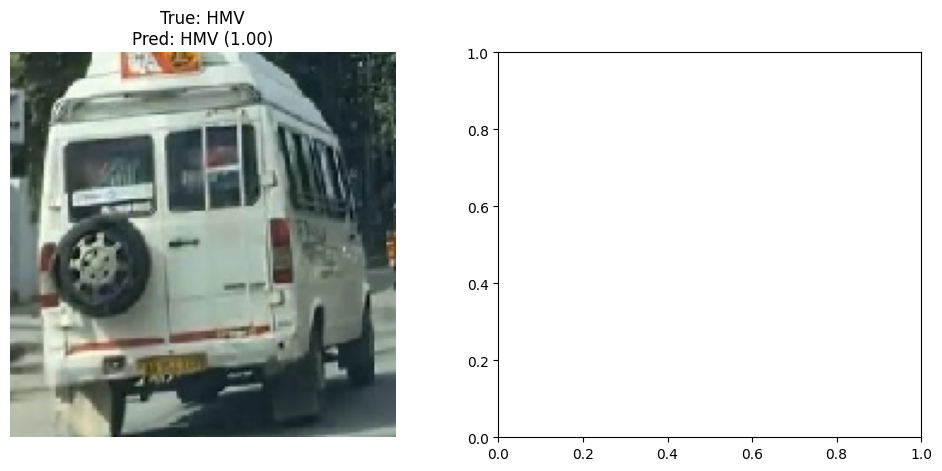

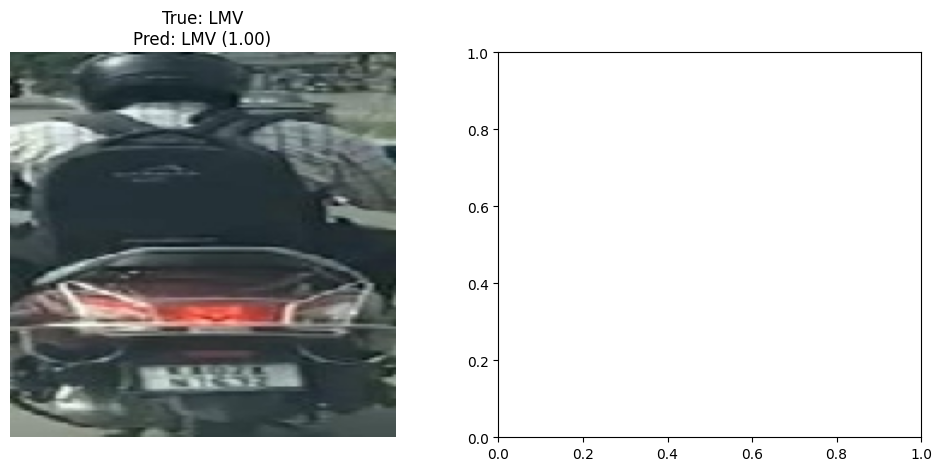

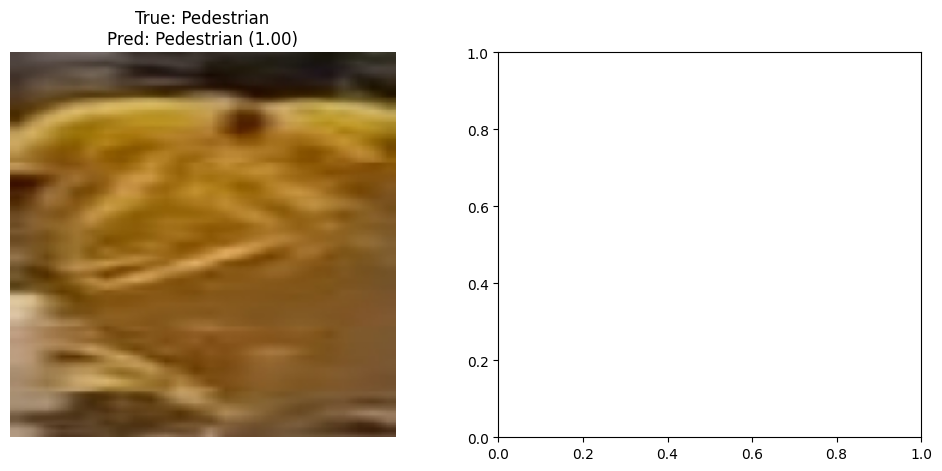

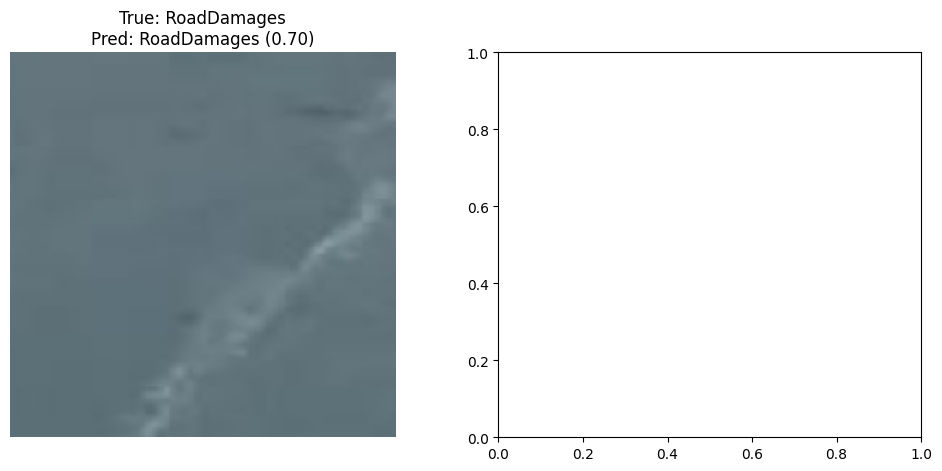

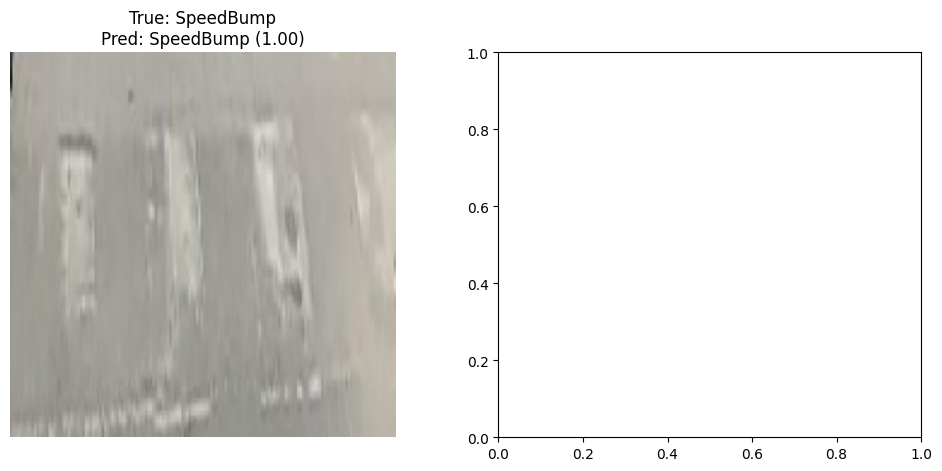

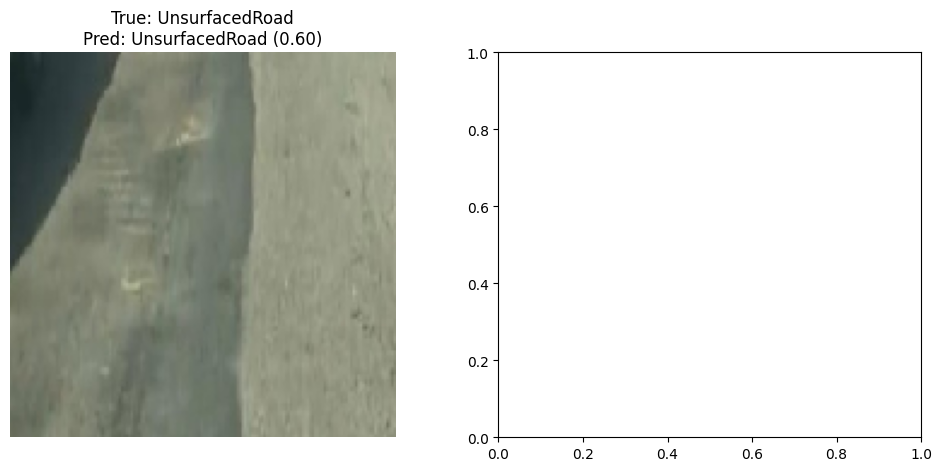

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shap
import matplotlib.pyplot as plt
import pickle
import gc
from tqdm import tqdm

# Constants
IMG_HEIGHT = 160
IMG_WIDTH = 160
CHANNELS = 3
BATCH_SIZE = 8
CLASS_NAMES = ['HMV', 'LMV', 'Pedestrian', 'RoadDamages', 'SpeedBump', 'UnsurfacedRoad']
OUTPUT_DIR = 'shap_results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Paths (update these with your actual paths)
TEST_PATHS = [
    '/content/dataset/kaggle/working/organized_dataset/test/HMV',
    '/content/dataset/kaggle/working/organized_dataset/test/LMV',
    '/content/dataset/kaggle/working/organized_dataset/test/Pedestrian',
    '/content/dataset/kaggle/working/organized_dataset/test/RoadDamages',
    '/content/dataset/kaggle/working/organized_dataset/test/SpeedBump',
    '/content/dataset/kaggle/working/organized_dataset/test/UnsurfacedRoad'
]
TRAIN_PATH = '/content/dataset/kaggle/working/organized_dataset/train'
MODEL_PATH = '/content/final_vgg16_model.keras'

# Save locations for SHAP explainer and background data
SHAP_EXPLAINER_PATH = os.path.join(OUTPUT_DIR, 'shap_explainer.pkl')
BACKGROUND_DATA_PATH = os.path.join(OUTPUT_DIR, 'shap_background.pkl')

# Load model
print(f"Loading model from {MODEL_PATH}")
model = load_model(MODEL_PATH)

def load_images_from_folder(folder, num_samples=None):
    """Load and preprocess images from a folder"""
    datagen = ImageDataGenerator(rescale=1./255)
    parent_dir = os.path.dirname(folder)
    class_name = os.path.basename(folder)

    print(f"Loading images from {folder}")
    generator = datagen.flow_from_directory(
        parent_dir,
        classes=[class_name],
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=True
    )

    images = []
    batches_needed = int(np.ceil(num_samples/BATCH_SIZE)) if num_samples else 1
    for i, batch in enumerate(generator):
        images.extend(batch)
        if num_samples and len(images) >= num_samples:
            break
        if i >= batches_needed:
            break

    images = np.array(images[:num_samples] if num_samples else images)
    print(f"Loaded {len(images)} images with shape {images.shape}")
    return images

def get_background_samples(num_samples=50):
    """Get balanced background samples"""
    background = []
    samples_per_class = max(1, num_samples // len(CLASS_NAMES))

    for class_name in tqdm(CLASS_NAMES, desc="Collecting background samples"):
        class_path = os.path.join(TRAIN_PATH, class_name)
        if os.path.exists(class_path):
            class_images = load_images_from_folder(class_path, samples_per_class)
            if len(class_images) > 0:
                background.extend(class_images)

    background = np.array(background)
    print(f"Collected {len(background)} background samples")
    return background

def create_shap_explainer(model, background):
    """Create SHAP explainer with proper shape handling"""
    print("Creating SHAP explainer...")

    # Make sure background has the right shape
    if len(background.shape) == 4:  # (samples, height, width, channels)
        background_samples = background
    else:
        raise ValueError(f"Unexpected background shape: {background.shape}")

    # Create a partition masker specifically for image data
    masker = shap.maskers.Image("inpaint_telea", background_samples[0].shape)

    # Create the SHAP explainer with the masker
    explainer = shap.Explainer(model_predict, masker, output_names=CLASS_NAMES)

    return explainer
    # Define the model wrapper function to process correctly shaped inputs
def model_predict(images):
    return model.predict(images)



def save_explainer(explainer, path):
    """Save the SHAP explainer to disk"""
    print(f"Saving SHAP explainer to {path}")
    try:
        with open(path, 'wb') as f:
            pickle.dump(explainer, f)
        print("Explainer saved successfully")
    except Exception as e:
        print(f"Error saving explainer: {e}")

def load_explainer(path):
    """Load the SHAP explainer from disk"""
    print(f"Loading SHAP explainer from {path}")
    try:
        with open(path, 'rb') as f:
            explainer = pickle.load(f)
        print("Explainer loaded successfully")
        return explainer
    except Exception as e:
        print(f"Error loading explainer: {e}")
        return None

def explain_test_samples(explainer, num_samples=1):
    """Generate explanations for test samples (1 per class)"""
    for class_path in TEST_PATHS:
        if not os.path.exists(class_path):
            print(f"Path not found: {class_path}")
            continue

        class_name = os.path.basename(class_path)
        print(f"\nProcessing class: {class_name}")

        # Load just one image per class
        test_images = load_images_from_folder(class_path, num_samples=1)
        if len(test_images) == 0:
            continue

        try:
            print("Computing SHAP values...")

            # Make sure test image has the right shape
            if len(test_images.shape) != 4:
                raise ValueError(f"Unexpected test images shape: {test_images.shape}")

            # Get the single image
            single_image = test_images[0:1]
            pred = model.predict(single_image)[0]
            pred_class = CLASS_NAMES[np.argmax(pred)]
            confidence = np.max(pred)
            pred_idx = np.argmax(pred)

            print(f"Explaining image (class {class_name})")

            # Compute SHAP values for this single image
            shap_values = explainer(single_image)

            plt.figure(figsize=(12, 5))

            # Original image
            plt.subplot(1, 2, 1)
            plt.imshow(test_images[0])
            plt.title(f"True: {class_name}\nPred: {pred_class} ({confidence:.2f})")
            plt.axis('off')

            # SHAP explanation - plot for the predicted class
            plt.subplot(1, 2, 2)

            # Handle the shape properly based on SHAP output structure
            try:
                # For newer SHAP versions with Explanation objects
                if hasattr(shap_values, 'values'):
                    if shap_values.values.ndim == 5:  # (samples, h, w, c, classes)
                        shap_image_values = shap_values.values[0, :, :, :, pred_idx]
                    else:  # (samples, h, w, c)
                        shap_image_values = shap_values.values[0]
                else:
                    # For older SHAP versions with numpy arrays
                    if isinstance(shap_values, list):
                        shap_image_values = shap_values[pred_idx][0]
                    else:
                        shap_image_values = shap_values[0]

                # Display the SHAP values
                shap.image_plot(shap_image_values, test_images[0], show=False)
            except Exception as viz_error:
                print(f"Visualization error: {viz_error}")
                # Fallback visualization
                plt.imshow(np.abs(shap_values.values[0]).sum(axis=-1))
                plt.title("SHAP importance heatmap")

            plt.axis('off')
            plt.tight_layout()
            plt.savefig(f"{OUTPUT_DIR}/{class_name}_explanation.png")
            plt.close()
            gc.collect()

        except Exception as e:
            print(f"Error explaining {class_name}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue

if __name__ == "__main__":
    print("GPU Available:", tf.config.list_physical_devices('GPU'))

    # Verify model
    dummy_input = np.random.rand(1, IMG_HEIGHT, IMG_WIDTH, CHANNELS)
    pred = model.predict(dummy_input)
    print("Model output shape:", pred.shape)
    assert pred.shape[1] == len(CLASS_NAMES), "Model output mismatch"

    # Check if we have a saved explainer
    if os.path.exists(SHAP_EXPLAINER_PATH) and os.path.exists(BACKGROUND_DATA_PATH):
        print("Loading saved SHAP explainer and background data...")
        explainer = load_explainer(SHAP_EXPLAINER_PATH)
        with open(BACKGROUND_DATA_PATH, 'rb') as f:
            background = pickle.load(f)
    else:
        # Get background samples
        print("Creating new background samples...")
        background = get_background_samples(50)
        print("Background shape:", background.shape)

        # Save background data
        print(f"Saving background data to {BACKGROUND_DATA_PATH}")
        with open(BACKGROUND_DATA_PATH, 'wb') as f:
            pickle.dump(background, f)

        # Create explainer
        explainer = create_shap_explainer(model, background)

        # Save explainer
        save_explainer(explainer, SHAP_EXPLAINER_PATH)

    # Generate explanations - only 1 image per class
    print("\nGenerating explanations...")
    explain_test_samples(explainer, num_samples=1)

    print("\nProcess completed! Check the 'shap_results' directory")

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shap
import matplotlib.pyplot as plt
import pickle
import gc
from tqdm import tqdm

# Constants
IMG_HEIGHT = 160
IMG_WIDTH = 160
CHANNELS = 3
BATCH_SIZE = 8
CLASS_NAMES = ['HMV', 'LMV', 'Pedestrian', 'RoadDamages', 'SpeedBump', 'UnsurfacedRoad']
OUTPUT_DIR = 'shap_results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Paths (update these with your actual paths)
TEST_PATHS = [
    '/content/dataset/kaggle/working/organized_dataset/test/HMV',
    '/content/dataset/kaggle/working/organized_dataset/test/LMV',
    '/content/dataset/kaggle/working/organized_dataset/test/Pedestrian',
    '/content/dataset/kaggle/working/organized_dataset/test/RoadDamages',
    '/content/dataset/kaggle/working/organized_dataset/test/SpeedBump',
    '/content/dataset/kaggle/working/organized_dataset/test/UnsurfacedRoad'
]
TRAIN_PATH = '/content/dataset/kaggle/working/organized_dataset/train'
MODEL_PATH = '/content/final_vgg16_model.keras'

# Save locations for SHAP explainer and background data
SHAP_EXPLAINER_PATH = os.path.join(OUTPUT_DIR, 'shap_explainer.pkl')
BACKGROUND_DATA_PATH = os.path.join(OUTPUT_DIR, 'shap_background.pkl')

# Load model
print(f"Loading model from {MODEL_PATH}")
model = load_model(MODEL_PATH)

def load_images_from_folder(folder, num_samples=None):
    """Load and preprocess images from a folder"""
    datagen = ImageDataGenerator(rescale=1./255)
    parent_dir = os.path.dirname(folder)
    class_name = os.path.basename(folder)

    print(f"Loading images from {folder}")
    generator = datagen.flow_from_directory(
        parent_dir,
        classes=[class_name],
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=True
    )

    images = []
    batches_needed = int(np.ceil(num_samples/BATCH_SIZE)) if num_samples else 1
    for i, batch in enumerate(generator):
        images.extend(batch)
        if num_samples and len(images) >= num_samples:
            break
        if i >= batches_needed:
            break

    images = np.array(images[:num_samples] if num_samples else images)
    print(f"Loaded {len(images)} images with shape {images.shape}")
    return images

def get_background_samples(num_samples=50):
    """Get balanced background samples"""
    background = []
    samples_per_class = max(1, num_samples // len(CLASS_NAMES))

    for class_name in tqdm(CLASS_NAMES, desc="Collecting background samples"):
        class_path = os.path.join(TRAIN_PATH, class_name)
        if os.path.exists(class_path):
            class_images = load_images_from_folder(class_path, samples_per_class)
            if len(class_images) > 0:
                background.extend(class_images)

    background = np.array(background)
    print(f"Collected {len(background)} background samples")
    return background

# Define the model wrapper function to process correctly shaped inputs
def model_predict(images):
    """Wrapper function for the model"""
    return model.predict(images)

def create_shap_explainer(model, background):
    """Create SHAP explainer with proper shape handling"""
    print("Creating SHAP explainer...")

    # Make sure background has the right shape
    if len(background.shape) == 4:  # (samples, height, width, channels)
        background_samples = background
    else:
        raise ValueError(f"Unexpected background shape: {background.shape}")

    # Create a partition masker specifically for image data
    masker = shap.maskers.Image("inpaint_telea", background_samples[0].shape)

    # Create the SHAP explainer with the masker
    explainer = shap.Explainer(model_predict, masker, output_names=CLASS_NAMES)

    return explainer

def save_explainer(explainer, path):
    """Save the SHAP explainer to disk"""
    print(f"Saving SHAP explainer to {path}")
    try:
        with open(path, 'wb') as f:
            pickle.dump(explainer, f)
        print("Explainer saved successfully")
    except Exception as e:
        print(f"Error saving explainer: {e}")

def load_explainer(path):
    """Load the SHAP explainer from disk"""
    print(f"Loading SHAP explainer from {path}")
    try:
        with open(path, 'rb') as f:
            explainer = pickle.load(f)
        print("Explainer loaded successfully")
        return explainer
    except Exception as e:
        print(f"Error loading explainer: {e}")
        return None

def explain_test_samples(explainer, num_samples=1):
    """Generate explanations for test samples (1 per class)"""
    for class_path in TEST_PATHS:
        if not os.path.exists(class_path):
            print(f"Path not found: {class_path}")
            continue

        class_name = os.path.basename(class_path)
        print(f"\nProcessing class: {class_name}")

        # Load just one image per class
        test_images = load_images_from_folder(class_path, num_samples=1)
        if len(test_images) == 0:
            continue

        try:
            print("Computing SHAP values...")

            # Make sure test image has the right shape
            if len(test_images.shape) != 4:
                raise ValueError(f"Unexpected test images shape: {test_images.shape}")

            # Get the single image
            single_image = test_images[0:1]
            pred = model.predict(single_image)[0]
            pred_class = CLASS_NAMES[np.argmax(pred)]
            confidence = np.max(pred)
            pred_idx = np.argmax(pred)

            print(f"Explaining image (class {class_name})")

            # Compute SHAP values for this single image
            shap_values = explainer(single_image)

            plt.figure(figsize=(12, 5))

            # Original image
            plt.subplot(1, 2, 1)
            plt.imshow(test_images[0])
            plt.title(f"True: {class_name}\nPred: {pred_class} ({confidence:.2f})")
            plt.axis('off')

            # SHAP explanation - plot for the predicted class
            plt.subplot(1, 2, 2)

            # Handle the shape properly based on SHAP output structure
            try:
                # For newer SHAP versions with Explanation objects
                if hasattr(shap_values, 'values'):
                    if shap_values.values.ndim == 5:  # (samples, h, w, c, classes)
                        shap_image_values = shap_values.values[0, :, :, :, pred_idx]
                    else:  # (samples, h, w, c)
                        shap_image_values = shap_values.values[0]
                else:
                    # For older SHAP versions with numpy arrays
                    if isinstance(shap_values, list):
                        shap_image_values = shap_values[pred_idx][0]
                    else:
                        shap_image_values = shap_values[0]

                # Display the SHAP values
                shap.image_plot(shap_image_values, test_images[0], show=False)
            except Exception as viz_error:
                print(f"Visualization error: {viz_error}")
                # Fallback visualization
                plt.imshow(np.abs(shap_values.values[0]).sum(axis=-1))
                plt.title("SHAP importance heatmap")

            plt.axis('off')
            plt.tight_layout()
            plt.savefig(f"{OUTPUT_DIR}/{class_name}_explanation.png")
            plt.close()
            gc.collect()

        except Exception as e:
            print(f"Error explaining {class_name}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue

if __name__ == "__main__":
    print("GPU Available:", tf.config.list_physical_devices('GPU'))

    # Verify model
    dummy_input = np.random.rand(1, IMG_HEIGHT, IMG_WIDTH, CHANNELS)
    pred = model.predict(dummy_input)
    print("Model output shape:", pred.shape)
    assert pred.shape[1] == len(CLASS_NAMES), "Model output mismatch"

    # The key fix: Always create a new explainer instead of trying to load
    # from a corrupted file
    print("Creating new background samples and explainer...")
    background = get_background_samples(50)
    print("Background shape:", background.shape)

    # Save background data
    print(f"Saving background data to {BACKGROUND_DATA_PATH}")
    with open(BACKGROUND_DATA_PATH, 'wb') as f:
        pickle.dump(background, f)

    # Create explainer
    explainer = create_shap_explainer(model, background)

    # Save explainer
    save_explainer(explainer, SHAP_EXPLAINER_PATH)

    # Generate explanations - only 1 image per class
    print("\nGenerating explanations...")
    explain_test_samples(explainer, num_samples=1)

    print("\nProcess completed! Check the 'shap_results' directory")

Loading model from /content/final_vgg16_model.keras
GPU Available: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Model output shape: (1, 6)
Creating new background samples and explainer...


Loading images from /content/dataset/kaggle/working/organized_dataset/train/HMV
Found 500 images belonging to 1 classes.
Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/LMV
Found 500 images belonging to 1 classes.


Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/Pedestrian
Found 500 images belonging to 1 classes.
Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/RoadDamages
Found 500 images belonging to 1 classes.


Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/SpeedBump
Found 346 images belonging to 1 classes.
Loaded 8 images with shape (8, 160, 160, 3)
Loading images from /content/dataset/kaggle/working/organized_dataset/train/UnsurfacedRoad
Found 405 images belonging to 1 classes.


Loaded 8 images with shape (8, 160, 160, 3)
Collected 48 background samples
Background shape: (48, 160, 160, 3)
Saving background data to shap_results/shap_background.pkl


Creating SHAP explainer...
Saving SHAP explainer to shap_results/shap_explainer.pkl
Explainer saved successfully

Generating explanations...

Processing class: HMV
Loading images from /content/dataset/kaggle/working/organized_dataset/test/HMV
Found 500 images belonging to 1 classes.
Loaded 1 images with shape (1, 160, 160, 3)
Computing SHAP values...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
Explaining image (class HMV)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 


PartitionExplainer explainer: 2it [04:13, 253.51s/it]              
<ipython-input-8-d8b0184c3e55>:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Processing class: LMV
Loading images from /content/dataset/kaggle/working/organized_dataset/test/LMV
Found 500 images belonging to 1 classes.
Loaded 1 images with shape (1, 160, 160, 3)
Computing SHAP values...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
Explaining image (class LMV)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 


PartitionExplainer explainer: 2it [04:24, 264.49s/it]              



Processing class: Pedestrian
Loading images from /content/dataset/kaggle/working/organized_dataset/test/Pedestrian
Found 500 images belonging to 1 classes.
Loaded 1 images with shape (1, 160, 160, 3)
Computing SHAP values...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
Explaining image (class Pedestrian)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 